In [1]:
!pip install torch-geometric

# !unzip "/content/Archive.zip"
# !rm -rf '/content/prepared_samples'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.6 MB/s eta 0:00:00


In [2]:
#create samples :
import os
import torch
import pickle
import pandas as pd

def load_graph(path, is_pickle=True):
    """
    Load a molecule graph (.pkl) or a protein graph (.pt).
    If is_pickle is True, use pickle to load the file; otherwise, use torch.load.
    """
    if is_pickle:
        with open(path, 'rb') as f:
            return pickle.load(f)
    else:
        return torch.load(path)

def prepare_dataset_individual_save_as_pt(filtered_dataset, molecule_graph_dir, protein_graph_dir, output_dir):
    """
    Incrementally prepares the dataset and saves each (molecule, protein, target) tuple as a separate .pt file.

    Args:
    - filtered_dataset: The filtered KIBA dataset (DataFrame).
    - molecule_graph_dir: Directory where molecule graphs are stored.
    - protein_graph_dir: Directory where protein graphs are stored.
    - output_dir: Directory to save the prepared dataset incrementally.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index, row in filtered_dataset.iterrows():
        protein_id = row['Target_ID']
        chembl_id = row['Drug_ID']

        # Load the protein graph (.pt)
        pro_graph_path = os.path.join(protein_graph_dir, f"{protein_id}_graph.pt")
        if not os.path.exists(pro_graph_path):
            print(f"Protein graph not found: {protein_id}")
            continue
        pro_graph = load_graph(pro_graph_path, is_pickle=False)

        # Load the molecule graph (.pkl)
        mol_graph_path = os.path.join(molecule_graph_dir, f"{chembl_id}_graph.pkl")
        if not os.path.exists(mol_graph_path):
            print(f"Molecule graph not found: {chembl_id}")
            continue
        mol_graph = load_graph(mol_graph_path)

        # Load target (affinity value)
        target = torch.tensor([row['Y']], dtype=torch.float)

        # Create the sample as a tuple (molecule graph, protein graph, target)
        sample = (mol_graph, pro_graph, target)

        # Save the sample as a .pt file
        sample_path = os.path.join(output_dir, f"sample_{index}.pt")
        torch.save(sample, sample_path)

        if(index%4000 == 0 ):
            print(f"Saved sample {index} as {sample_path}")




# Example usage for individual saving
molecule_graph_dir = '/kaggle/input/graphs/molecule_graphs'  # Directory where molecule graphs are stored
protein_graph_dir = '/kaggle/input/graphs/ProteinGraphs'  # Directory where protein graphs are stored
filtered_dataset_path = '/kaggle/input/graphs/filtered_DavisDataSet.csv'  # Path to the filtered dataset CSV
output_dir = 'prepared_samples/'  # Directory to save individual samples

# Load filtered dataset CSV
filtered_dataset = pd.read_csv(filtered_dataset_path)

# Prepare the dataset incrementally, saving each sample as a .pt file
prepare_dataset_individual_save_as_pt(filtered_dataset, molecule_graph_dir, protein_graph_dir, output_dir)

print("Dataset preparation completed.")


<ipython-input-2-978404414efb>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


Saved sample 0 as prepared_samples/sample_0.pt


<ipython-input-2-978404414efb>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


Saved sample 4000 as prepared_samples/sample_4000.pt
Saved sample 8000 as prepared_samples/sample_8000.pt
Saved sample 12000 as prepared_samples/sample_12000.pt
Saved sample 16000 as prepared_samples/sample_16000.pt
Dataset preparation completed.


In [3]:
#model cat the mul and add
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import MSELoss
from torch_geometric.nn import GCNConv, global_mean_pool as gep
from torch_geometric.data import Data, Batch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

# Optional, for plotting:
import matplotlib.pyplot as plt

##############################################################################
#                               1. METRICS
##############################################################################

@torch.no_grad()
def ci_vectorized(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Naive O(N^2) Concordance Index using vectorized GPU operations.
    preds, targets: (N,) on the same device (e.g. cuda).
    """
    # (N, N) differences
    p_diff = preds.unsqueeze(1) - preds.unsqueeze(0)
    t_diff = targets.unsqueeze(1) - targets.unsqueeze(0)
    # mask out pairs where targets are identical
    mask = (t_diff != 0)
    # sign of product => +1 (concordant), 0 (tie), -1 (discordant)
    sign_mat = torch.sign(p_diff * t_diff)
    # step function h(x): 1 if x>0, 0.5 if x=0, 0 if x<0
    h = (sign_mat == 1).float() + 0.5 * (sign_mat == 0).float()
    # apply mask
    h_masked = h * mask.float()
    c = h_masked.sum()
    s = mask.sum().float()
    return (c / s).item() if s > 0 else 0.0

@torch.no_grad()
def mse_torch(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    GPU-friendly MSE using torch's built-in mean squared error.
    """
    return F.mse_loss(preds, targets, reduction='mean').item()

@torch.no_grad()
def pearson_torch(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Pearson correlation coefficient in PyTorch (GPU-friendly).
    preds, targets: (N,) on the same device
    """
    p_centered = preds - preds.mean()
    t_centered = targets - targets.mean()
    cov = (p_centered * t_centered).sum()
    denom = torch.sqrt((p_centered**2).sum()) * torch.sqrt((t_centered**2).sum())
    eps = 1e-8
    return (cov / (denom + eps)).item()

##############################################################################
#                       2. GNN MODEL DEFINITION
##############################################################################

class GNNNet(torch.nn.Module):
    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78, output_dim=128, dropout=0.2):
        super(GNNNet, self).__init__()

        print('GNNNet Loaded')
        self.n_output = n_output
        self.mol_conv1 = GCNConv(num_features_mol, num_features_mol)
        self.mol_conv2 = GCNConv(num_features_mol, num_features_mol * 2)
        self.mol_conv3 = GCNConv(num_features_mol * 2, num_features_mol * 4)
        self.mol_fc_g1 = torch.nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = torch.nn.Linear(1024, output_dim)

        # self.pro_conv1 = GCNConv(embed_dim, embed_dim)
        self.pro_conv1 = GCNConv(num_features_pro, num_features_pro)
        self.pro_conv2 = GCNConv(num_features_pro, num_features_pro * 2)
        self.pro_conv3 = GCNConv(num_features_pro * 2, num_features_pro * 4)
        # self.pro_conv4 = GCNConv(embed_dim * 4, embed_dim * 8)
        self.pro_fc_g1 = torch.nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = torch.nn.Linear(1024, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # combined layers
        self.fc1 = nn.Linear(2 * output_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, self.n_output)

    def forward(self, data_mol, data_pro):
        # get graph input
        mol_x, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch
        # get protein input
        target_x, target_edge_index, target_batch = data_pro.x, data_pro.edge_index, data_pro.batch

        # target_seq=data_pro.target

        # print('size')
        # print('mol_x', mol_x.size(), 'edge_index', mol_edge_index.size(), 'batch', mol_batch.size())
        # print('target_x', target_x.size(), 'target_edge_index', target_batch.size(), 'batch', target_batch.size())

        x = self.mol_conv1(mol_x, mol_edge_index)
        x = self.relu(x)

        # mol_edge_index, _ = dropout_adj(mol_edge_index, training=self.training)
        x = self.mol_conv2(x, mol_edge_index)
        x = self.relu(x)

        # mol_edge_index, _ = dropout_adj(mol_edge_index, training=self.training)
        x = self.mol_conv3(x, mol_edge_index)
        x = self.relu(x)
        x = gep(x, mol_batch)  # global pooling

        # flatten
        x = self.relu(self.mol_fc_g1(x))
        x = self.dropout(x)
        x = self.mol_fc_g2(x)
        x = self.dropout(x)

        xt = self.pro_conv1(target_x, target_edge_index)
        xt = self.relu(xt)

        # target_edge_index, _ = dropout_adj(target_edge_index, training=self.training)
        xt = self.pro_conv2(xt, target_edge_index)
        xt = self.relu(xt)

        # target_edge_index, _ = dropout_adj(target_edge_index, training=self.training)
        xt = self.pro_conv3(xt, target_edge_index)
        xt = self.relu(xt)

        # xt = self.pro_conv4(xt, target_edge_index)
        # xt = self.relu(xt)
        xt = gep(xt, target_batch)  # global pooling

        # flatten
        xt = self.relu(self.pro_fc_g1(xt))
        xt = self.dropout(xt)
        xt = self.pro_fc_g2(xt)
        xt = self.dropout(xt)

        # print("sizes of out coming gnns",x.size(), xt.size())

        # print("Before combining:")
        # print(f"x stats -> min: {x.min().item()}, max: {x.max().item()}, mean: {x.mean().item()}")
        # print(f"xt stats -> min: {xt.min().item()}, max: {xt.max().item()}, mean: {xt.mean().item()}")
        
        # # Try different ways of combining x and xt
        # xc_concat = torch.cat((x, xt), 1)  # Concatenation
        # xc_mult = x * xt  # Element-wise multiplication
        # xc_add = x + xt  # Addition (only if ranges are similar)
        
        # print("After combining:")
        # print(f"xc_concat shape: {xc_concat.shape}")
        # print(f"xc_mult stats -> min: {xc_mult.min().item()}, max: {xc_mult.max().item()}, mean: {xc_mult.mean().item()}")
        # print(f"xc_add stats -> min: {xc_add.min().item()}, max: {xc_add.max().item()}, mean: {xc_add.mean().item()}")

        #cad the add and the ,u; insted of concat !
        xc1 = x + xt
        xc2 = x * xt
        xc = torch.cat((xc1, xc2), 1)
        # concat
        # xc = torch.cat((x, xt), 1)
        # print('after concat',xc.size())
        # add some dense layers
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out

##############################################################################
#                   3. DATA LOADING HELPERS
##############################################################################

warnings.filterwarnings('ignore', category=FutureWarning)

def load_sample(path):
    """
    Load a .pt sample, fix up 'x' and 'edge_index', return (mol_data, pro_data, target).
    """
    sample = torch.load(path)
    mol_data, pro_data, target = sample[0], sample[1], sample[2]

    # Convert dict to Data if needed
    if isinstance(mol_data, dict):
        mol_data = Data(**mol_data)
    if isinstance(pro_data, dict):
        pro_data = Data(**pro_data)

    # Fix x
    if not hasattr(mol_data, 'x') or mol_data.x is None:
        if hasattr(mol_data, 'features'):
            mol_data.x = mol_data.features
            del mol_data.features
        else:
            raise ValueError("mol_data missing 'x' or 'features'")
    if not hasattr(pro_data, 'x') or pro_data.x is None:
        if hasattr(pro_data, 'features'):
            pro_data.x = pro_data.features
            del pro_data.features
        else:
            raise ValueError("pro_data missing 'x' or 'features'")

    mol_data.x = torch.as_tensor(mol_data.x, dtype=torch.float32)
    pro_data.x = torch.as_tensor(pro_data.x, dtype=torch.float32)

    # Fix edge_index
    def fix_edge_index(d):
        if not isinstance(d.edge_index, torch.Tensor):
            d.edge_index = torch.tensor(d.edge_index, dtype=torch.long)
        else:
            d.edge_index = d.edge_index.long()
        if d.edge_index.shape[0] != 2:
            d.edge_index = d.edge_index.t()
        d.num_nodes = d.x.size(0)

    fix_edge_index(mol_data)
    fix_edge_index(pro_data)

    return (mol_data, pro_data, target)

def batch_loader(file_list, sample_dir, batch_size):
    """
    Yields batches of (mol_data, pro_data, target) from file_list.
    """
    batch = []
    for file_name in file_list:
        path = os.path.join(sample_dir, file_name)
        sample = load_sample(path)
        batch.append(sample)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:
        yield batch

##############################################################################
#              4. TRAINING / EVALUATION WITH METRICS EACH EPOCH
##############################################################################

import os
import torch

def train_and_evaluate(sample_dir, num_epochs=10, test_size=0.2, lr=0.001):
    """
    Trains the GNN model, evaluates on train & test each epoch, saves metrics + checkpoints.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on {device}.")

    # Gather samples
    sample_files = [f for f in os.listdir(sample_dir) if f.endswith('.pt')]
    assert len(sample_files) > 0, "No .pt files found in sample_dir!"

    # Split
    train_files, test_files = train_test_split(sample_files, test_size=test_size, random_state=42)

    # Make checkpoint dir
    training_model_dir = os.path.join(os.getcwd(), 'TrainingModelCATTHEADD&MU')
    os.makedirs(training_model_dir, exist_ok=True)
    print(f"Checkpoints will be saved to: {training_model_dir}")

    metrics_path = os.path.join(training_model_dir, "training_metrics.pt")

    # Load existing metrics if available (Ensures metrics continue from previous runs)
    if os.path.exists(metrics_path):
        saved_metrics = torch.load(metrics_path)
        train_metrics = saved_metrics['train_metrics']
        test_metrics = saved_metrics['test_metrics']
        print("Loaded previous training metrics!")
    else:
        train_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
        test_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
        print("Starting fresh metrics tracking.")

    # Infer input dims from one sample
    sample0 = load_sample(os.path.join(sample_dir, train_files[0]))
    mol_data0, pro_data0 = sample0[0], sample0[1]
    num_features_mol = mol_data0.x.size(1)
    num_features_pro = pro_data0.x.size(1)

    # Initialize model
    model = GNNNet(num_features_mol=num_features_mol,
                   num_features_pro=num_features_pro).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    # Possibly resume from checkpoint
    start_epoch = 1
    existing_checkpoints = [
        f for f in os.listdir(training_model_dir)
        if f.endswith('.pt') and f.startswith('model_epoch')
    ]
    last_ckpt_path = None  # Track previous checkpoint for deletion

    if existing_checkpoints:
        latest_ckpt = max(existing_checkpoints, key=lambda x: int(x.split('_epoch')[1].split('.pt')[0]))
        ckpt_path = os.path.join(training_model_dir, latest_ckpt)
        print(f"Loading checkpoint from {ckpt_path}")
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        loaded_epoch = ckpt['epoch']
        start_epoch = loaded_epoch + 1
        last_ckpt_path = ckpt_path  # Store last checkpoint path for deletion
        print(f"Resuming from epoch {start_epoch}")
    else:
        print("No existing checkpoint found; starting fresh.")

    @torch.no_grad()
    def evaluate(files):
        model.eval()
        all_preds = []
        all_targets = []
        batch_eval_size = 200
        for batch_samples in batch_loader(files, sample_dir, batch_eval_size):
            mol_list, pro_list, tgt_list = [], [], []
            for (md, pd, t) in batch_samples:
                mol_list.append(md)
                pro_list.append(pd)
                tgt_list.append(t)

            mol_batch = Batch.from_data_list(mol_list).to(device)
            pro_batch = Batch.from_data_list(pro_list).to(device)
            t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device)

            out = model(mol_batch, pro_batch).view(-1)
            all_preds.append(out)
            all_targets.append(t_tensor)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        mse_val = mse_torch(all_preds, all_targets)
        ci_val = ci_vectorized(all_preds, all_targets)
        pearson_val = pearson_torch(all_preds, all_targets)
        return mse_val, ci_val, pearson_val

    # Training loop
    batch_size = 200
    for epoch in tqdm(range(start_epoch, num_epochs + 1), desc="Training", unit="epoch"):
        model.train()
        running_loss = 0.0

        for batch_samples in batch_loader(train_files, sample_dir, batch_size):
            mol_list, pro_list, tgt_list = [], [], []
            for (md, pd, t) in batch_samples:
                mol_list.append(md)
                pro_list.append(pd)
                tgt_list.append(t)

            mol_batch = Batch.from_data_list(mol_list).to(device)
            pro_batch = Batch.from_data_list(pro_list).to(device)
            t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device).view(-1)

            optimizer.zero_grad()
            out = model(mol_batch, pro_batch).view(-1)
            loss = loss_fn(out, t_tensor)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(batch_samples)

        avg_loss = running_loss / len(train_files)
        tqdm.write(f"[Epoch {epoch}/{num_epochs}] Training Loss: {avg_loss:.4f}")

        # Evaluate on train & test
        train_mse, train_ci, train_pearson = evaluate(train_files)
        test_mse, test_ci, test_pearson = evaluate(test_files)

        train_metrics['epoch'].append(epoch)
        train_metrics['mse'].append(train_mse)
        train_metrics['ci'].append(train_ci)
        train_metrics['pearson'].append(train_pearson)

        test_metrics['epoch'].append(epoch)
        test_metrics['mse'].append(test_mse)
        test_metrics['ci'].append(test_ci)
        test_metrics['pearson'].append(test_pearson)

        tqdm.write(f"  Train => MSE={train_mse:.4f}, CI={train_ci:.4f}, Pearson={train_pearson:.4f}")
        tqdm.write(f"  Test  => MSE={test_mse:.4f}, CI={test_ci:.4f}, Pearson={test_pearson:.4f}")

        # Save new checkpoint
        ckpt_name = f"model_epoch{epoch}.pt"
        ckpt_path = os.path.join(training_model_dir, ckpt_name)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, ckpt_path)
        tqdm.write(f"Checkpoint saved at epoch {epoch}")

        # Delete the previous checkpoint after saving the new one
        if last_ckpt_path and os.path.exists(last_ckpt_path):
            os.remove(last_ckpt_path)
            tqdm.write(f"Deleted previous checkpoint: {last_ckpt_path}")

        # Update last checkpoint path
        last_ckpt_path = ckpt_path

        # Save/Update the metrics after each epoch
        torch.save({
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        }, metrics_path)

    # Final evaluations
    final_train_mse, final_train_ci, final_train_pearson = evaluate(train_files)
    final_test_mse, final_test_ci, final_test_pearson = evaluate(test_files)
    print(f"\nFinal Train => MSE={final_train_mse:.4f}, CI={final_train_ci:.4f}, Pearson={final_train_pearson:.4f}")
    print(f"Final Test  => MSE={final_test_mse:.4f}, CI={final_test_ci:.4f}, Pearson={final_test_pearson:.4f}")

    # Save final metrics
    torch.save({
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }, metrics_path)
    print(f"Metrics saved to {metrics_path}")

    return train_metrics, test_metrics


##############################################################################
#               5. OPTIONAL: PLOT THE SAVED METRICS
##############################################################################

def plot_metrics(checkpoint_dir='TrainingModelCATTHEADD&MU'):
    """
    Load training_metrics.pt from the checkpoint_dir and plot MSE, CI, Pearson over epochs.
    """
    metrics_path = os.path.join(checkpoint_dir, "training_metrics.pt")
    if not os.path.exists(metrics_path):
        print(f"No metrics file found at {metrics_path}!")
        return

    saved_data = torch.load(metrics_path)
    train_metrics = saved_data['train_metrics']
    test_metrics = saved_data['test_metrics']
    epochs = train_metrics['epoch']

    # Plot MSE
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['mse'], 'o-', label='Train MSE')
    plt.plot(epochs, test_metrics['mse'], 'o-', label='Test MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "MSE_plot.png"))  
    plt.show()

    # Plot CI
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['ci'], 'o-', label='Train CI')
    plt.plot(epochs, test_metrics['ci'], 'o-', label='Test CI')
    plt.xlabel('Epoch')
    plt.ylabel('Concordance Index')
    plt.title('CI over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "CI_plot.png"))  
    plt.show()

    # Plot Pearson
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['pearson'], 'o-', label='Train Pearson')
    plt.plot(epochs, test_metrics['pearson'], 'o-', label='Test Pearson')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.title('Pearson Correlation over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "PEARSON_plot.png"))  
    plt.show()

##############################################################################
#                                 MAIN
##############################################################################

if __name__ == "__main__":
    # Adjust the paths/parameters as needed
    SAMPLE_DIR = "prepared_samples"   # Directory with your .pt samples
    NUM_EPOCHS = 250
    TEST_SPLIT = 0.2
    LR = 0.001

    # 1) Train and evaluate
    train_metrics, test_metrics = train_and_evaluate(
        sample_dir=SAMPLE_DIR,
        num_epochs=NUM_EPOCHS,
        test_size=TEST_SPLIT,
        lr=LR
    )

    # 2) Plot the metrics
    plot_metrics('TrainingModelCATTHEADD&MUL')



Running on cuda.
Checkpoints will be saved to: /kaggle/working/TrainingModelCATTHEADD&MU
Starting fresh metrics tracking.
GNNNet Loaded
No existing checkpoint found; starting fresh.


Training:   0%|          | 0/250 [00:33<?, ?epoch/s]

[Epoch 1/250] Training Loss: 2.9313


Training:   0%|          | 1/250 [01:11<4:56:47, 71.51s/epoch]

  Train => MSE=0.7568, CI=0.5629, Pearson=0.1641
  Test  => MSE=0.7354, CI=0.5542, Pearson=0.1390
Checkpoint saved at epoch 1


Training:   0%|          | 1/250 [01:43<4:56:47, 71.51s/epoch]

[Epoch 2/250] Training Loss: 0.8448


Training:   1%|          | 2/250 [02:18<4:45:08, 68.99s/epoch]

  Train => MSE=0.7404, CI=0.6780, Pearson=0.3355
  Test  => MSE=0.7217, CI=0.6655, Pearson=0.3233
Checkpoint saved at epoch 2
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch1.pt


Training:   1%|          | 2/250 [02:50<4:45:08, 68.99s/epoch]

[Epoch 3/250] Training Loss: 0.7972


Training:   1%|          | 3/250 [03:26<4:40:49, 68.22s/epoch]

  Train => MSE=0.6734, CI=0.7005, Pearson=0.3771
  Test  => MSE=0.6627, CI=0.6874, Pearson=0.3638
Checkpoint saved at epoch 3
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch2.pt


Training:   1%|          | 3/250 [03:57<4:40:49, 68.22s/epoch]

[Epoch 4/250] Training Loss: 0.7461


Training:   2%|▏         | 4/250 [04:32<4:37:13, 67.62s/epoch]

  Train => MSE=0.6764, CI=0.7257, Pearson=0.4298
  Test  => MSE=0.6712, CI=0.7109, Pearson=0.4140
Checkpoint saved at epoch 4
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch3.pt


Training:   2%|▏         | 4/250 [05:04<4:37:13, 67.62s/epoch]

[Epoch 5/250] Training Loss: 0.7067


Training:   2%|▏         | 5/250 [05:39<4:35:21, 67.44s/epoch]

  Train => MSE=0.6102, CI=0.7414, Pearson=0.4678
  Test  => MSE=0.6014, CI=0.7288, Pearson=0.4543
Checkpoint saved at epoch 5
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch4.pt


Training:   2%|▏         | 5/250 [06:12<4:35:21, 67.44s/epoch]

[Epoch 6/250] Training Loss: 0.6924


Training:   2%|▏         | 6/250 [06:47<4:34:06, 67.40s/epoch]

  Train => MSE=0.9551, CI=0.7507, Pearson=0.4844
  Test  => MSE=0.9642, CI=0.7375, Pearson=0.4689
Checkpoint saved at epoch 6
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch5.pt


Training:   2%|▏         | 6/250 [07:19<4:34:06, 67.40s/epoch]

[Epoch 7/250] Training Loss: 0.6946


Training:   3%|▎         | 7/250 [07:54<4:32:23, 67.26s/epoch]

  Train => MSE=0.7304, CI=0.7555, Pearson=0.4992
  Test  => MSE=0.7314, CI=0.7450, Pearson=0.4871
Checkpoint saved at epoch 7
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch6.pt


Training:   3%|▎         | 7/250 [08:26<4:32:23, 67.26s/epoch]

[Epoch 8/250] Training Loss: 0.6661


Training:   3%|▎         | 8/250 [09:01<4:31:30, 67.31s/epoch]

  Train => MSE=0.8010, CI=0.7600, Pearson=0.5080
  Test  => MSE=0.8081, CI=0.7500, Pearson=0.4946
Checkpoint saved at epoch 8
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch7.pt


Training:   3%|▎         | 8/250 [09:33<4:31:30, 67.31s/epoch]

[Epoch 9/250] Training Loss: 0.6570


Training:   4%|▎         | 9/250 [10:08<4:30:09, 67.26s/epoch]

  Train => MSE=0.7764, CI=0.7619, Pearson=0.5195
  Test  => MSE=0.7846, CI=0.7521, Pearson=0.5051
Checkpoint saved at epoch 9
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch8.pt


Training:   4%|▎         | 9/250 [10:40<4:30:09, 67.26s/epoch]

[Epoch 10/250] Training Loss: 0.6438


Training:   4%|▍         | 10/250 [11:16<4:29:32, 67.38s/epoch]

  Train => MSE=0.7520, CI=0.7615, Pearson=0.5206
  Test  => MSE=0.7595, CI=0.7519, Pearson=0.5069
Checkpoint saved at epoch 10
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch9.pt


Training:   4%|▍         | 10/250 [11:48<4:29:32, 67.38s/epoch]

[Epoch 11/250] Training Loss: 0.6378


Training:   4%|▍         | 11/250 [12:23<4:27:46, 67.22s/epoch]

  Train => MSE=0.6260, CI=0.7613, Pearson=0.5266
  Test  => MSE=0.6241, CI=0.7538, Pearson=0.5143
Checkpoint saved at epoch 11
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch10.pt


Training:   4%|▍         | 11/250 [12:55<4:27:46, 67.22s/epoch]

[Epoch 12/250] Training Loss: 0.6229


Training:   5%|▍         | 12/250 [13:30<4:27:13, 67.37s/epoch]

  Train => MSE=0.6193, CI=0.7637, Pearson=0.5299
  Test  => MSE=0.6213, CI=0.7561, Pearson=0.5180
Checkpoint saved at epoch 12
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch11.pt


Training:   5%|▍         | 12/250 [14:02<4:27:13, 67.37s/epoch]

[Epoch 13/250] Training Loss: 0.6230


Training:   5%|▌         | 13/250 [14:38<4:25:50, 67.30s/epoch]

  Train => MSE=0.5876, CI=0.7639, Pearson=0.5321
  Test  => MSE=0.5851, CI=0.7578, Pearson=0.5226
Checkpoint saved at epoch 13
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch12.pt


Training:   5%|▌         | 13/250 [15:10<4:25:50, 67.30s/epoch]

[Epoch 14/250] Training Loss: 0.6142


Training:   6%|▌         | 14/250 [15:45<4:24:41, 67.30s/epoch]

  Train => MSE=0.7038, CI=0.7686, Pearson=0.5401
  Test  => MSE=0.7116, CI=0.7616, Pearson=0.5292
Checkpoint saved at epoch 14
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch13.pt


Training:   6%|▌         | 14/250 [16:17<4:24:41, 67.30s/epoch]

[Epoch 15/250] Training Loss: 0.6141


Training:   6%|▌         | 15/250 [16:52<4:23:21, 67.24s/epoch]

  Train => MSE=0.7972, CI=0.7667, Pearson=0.5355
  Test  => MSE=0.8101, CI=0.7596, Pearson=0.5256
Checkpoint saved at epoch 15
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch14.pt


Training:   6%|▌         | 15/250 [17:24<4:23:21, 67.24s/epoch]

[Epoch 16/250] Training Loss: 0.6171


Training:   6%|▋         | 16/250 [17:59<4:22:16, 67.25s/epoch]

  Train => MSE=0.5769, CI=0.7710, Pearson=0.5441
  Test  => MSE=0.5747, CI=0.7649, Pearson=0.5355
Checkpoint saved at epoch 16
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch15.pt


Training:   6%|▋         | 16/250 [18:31<4:22:16, 67.25s/epoch]

[Epoch 17/250] Training Loss: 0.5947


Training:   7%|▋         | 17/250 [19:06<4:21:00, 67.21s/epoch]

  Train => MSE=0.6790, CI=0.7673, Pearson=0.5402
  Test  => MSE=0.6855, CI=0.7622, Pearson=0.5332
Checkpoint saved at epoch 17
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch16.pt


Training:   7%|▋         | 17/250 [19:39<4:21:00, 67.21s/epoch]

[Epoch 18/250] Training Loss: 0.5951


Training:   7%|▋         | 18/250 [20:14<4:19:49, 67.19s/epoch]

  Train => MSE=0.6146, CI=0.7747, Pearson=0.5510
  Test  => MSE=0.6204, CI=0.7689, Pearson=0.5433
Checkpoint saved at epoch 18
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch17.pt


Training:   7%|▋         | 18/250 [20:46<4:19:49, 67.19s/epoch]

[Epoch 19/250] Training Loss: 0.5920


Training:   8%|▊         | 19/250 [21:21<4:18:28, 67.14s/epoch]

  Train => MSE=0.5699, CI=0.7750, Pearson=0.5569
  Test  => MSE=0.5747, CI=0.7688, Pearson=0.5489
Checkpoint saved at epoch 19
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch18.pt


Training:   8%|▊         | 19/250 [21:53<4:18:28, 67.14s/epoch]

[Epoch 20/250] Training Loss: 0.5908


Training:   8%|▊         | 20/250 [22:28<4:17:36, 67.20s/epoch]

  Train => MSE=0.5283, CI=0.7808, Pearson=0.5717
  Test  => MSE=0.5301, CI=0.7748, Pearson=0.5635
Checkpoint saved at epoch 20
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch19.pt


Training:   8%|▊         | 20/250 [23:00<4:17:36, 67.20s/epoch]

[Epoch 21/250] Training Loss: 0.5823


Training:   8%|▊         | 21/250 [23:35<4:15:58, 67.07s/epoch]

  Train => MSE=0.4957, CI=0.7855, Pearson=0.5867
  Test  => MSE=0.4826, CI=0.7799, Pearson=0.5798
Checkpoint saved at epoch 21
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch20.pt


Training:   8%|▊         | 21/250 [24:07<4:15:58, 67.07s/epoch]

[Epoch 22/250] Training Loss: 0.5757


Training:   9%|▉         | 22/250 [24:41<4:14:34, 66.99s/epoch]

  Train => MSE=0.5638, CI=0.7806, Pearson=0.5785
  Test  => MSE=0.5730, CI=0.7747, Pearson=0.5724
Checkpoint saved at epoch 22
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch21.pt


Training:   9%|▉         | 22/250 [25:14<4:14:34, 66.99s/epoch]

[Epoch 23/250] Training Loss: 0.5665


Training:   9%|▉         | 23/250 [25:49<4:13:48, 67.09s/epoch]

  Train => MSE=0.6977, CI=0.7841, Pearson=0.5820
  Test  => MSE=0.7257, CI=0.7779, Pearson=0.5756
Checkpoint saved at epoch 23
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch22.pt


Training:   9%|▉         | 23/250 [26:21<4:13:48, 67.09s/epoch]

[Epoch 24/250] Training Loss: 0.5573


Training:  10%|▉         | 24/250 [26:55<4:12:13, 66.96s/epoch]

  Train => MSE=0.6430, CI=0.7875, Pearson=0.5917
  Test  => MSE=0.6657, CI=0.7814, Pearson=0.5849
Checkpoint saved at epoch 24
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch23.pt


Training:  10%|▉         | 24/250 [27:27<4:12:13, 66.96s/epoch]

[Epoch 25/250] Training Loss: 0.5580


Training:  10%|█         | 25/250 [28:02<4:10:26, 66.78s/epoch]

  Train => MSE=0.7155, CI=0.7839, Pearson=0.5827
  Test  => MSE=0.7499, CI=0.7778, Pearson=0.5763
Checkpoint saved at epoch 25
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch24.pt


Training:  10%|█         | 25/250 [28:34<4:10:26, 66.78s/epoch]

[Epoch 26/250] Training Loss: 0.5532


Training:  10%|█         | 26/250 [29:08<4:09:01, 66.70s/epoch]

  Train => MSE=0.5280, CI=0.7906, Pearson=0.5967
  Test  => MSE=0.5408, CI=0.7837, Pearson=0.5894
Checkpoint saved at epoch 26
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch25.pt


Training:  10%|█         | 26/250 [29:40<4:09:01, 66.70s/epoch]

[Epoch 27/250] Training Loss: 0.5383


Training:  11%|█         | 27/250 [30:15<4:07:33, 66.61s/epoch]

  Train => MSE=0.9441, CI=0.7868, Pearson=0.5898
  Test  => MSE=1.0040, CI=0.7801, Pearson=0.5825
Checkpoint saved at epoch 27
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch26.pt


Training:  11%|█         | 27/250 [30:46<4:07:33, 66.61s/epoch]

[Epoch 28/250] Training Loss: 0.5651


Training:  11%|█         | 28/250 [31:21<4:06:23, 66.59s/epoch]

  Train => MSE=0.5823, CI=0.7908, Pearson=0.6003
  Test  => MSE=0.6068, CI=0.7830, Pearson=0.5914
Checkpoint saved at epoch 28
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch27.pt


Training:  11%|█         | 28/250 [31:53<4:06:23, 66.59s/epoch]

[Epoch 29/250] Training Loss: 0.5364


Training:  12%|█▏        | 29/250 [32:28<4:05:19, 66.60s/epoch]

  Train => MSE=0.4766, CI=0.7974, Pearson=0.6166
  Test  => MSE=0.4804, CI=0.7881, Pearson=0.6073
Checkpoint saved at epoch 29
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch28.pt


Training:  12%|█▏        | 29/250 [33:00<4:05:19, 66.60s/epoch]

[Epoch 30/250] Training Loss: 0.5317


Training:  12%|█▏        | 30/250 [33:35<4:04:14, 66.61s/epoch]

  Train => MSE=0.5619, CI=0.7971, Pearson=0.6111
  Test  => MSE=0.5850, CI=0.7887, Pearson=0.6015
Checkpoint saved at epoch 30
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch29.pt


Training:  12%|█▏        | 30/250 [34:06<4:04:14, 66.61s/epoch]

[Epoch 31/250] Training Loss: 0.5265


Training:  12%|█▏        | 31/250 [34:41<4:03:13, 66.64s/epoch]

  Train => MSE=0.5773, CI=0.7937, Pearson=0.6086
  Test  => MSE=0.6014, CI=0.7846, Pearson=0.5996
Checkpoint saved at epoch 31
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch30.pt


Training:  12%|█▏        | 31/250 [35:13<4:03:13, 66.64s/epoch]

[Epoch 32/250] Training Loss: 0.5340


Training:  13%|█▎        | 32/250 [35:48<4:02:08, 66.64s/epoch]

  Train => MSE=0.6171, CI=0.8017, Pearson=0.6230
  Test  => MSE=0.6487, CI=0.7923, Pearson=0.6122
Checkpoint saved at epoch 32
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch31.pt


Training:  13%|█▎        | 32/250 [36:20<4:02:08, 66.64s/epoch]

[Epoch 33/250] Training Loss: 0.5272


Training:  13%|█▎        | 33/250 [36:54<4:00:58, 66.63s/epoch]

  Train => MSE=0.5442, CI=0.8004, Pearson=0.6258
  Test  => MSE=0.5624, CI=0.7906, Pearson=0.6159
Checkpoint saved at epoch 33
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch32.pt


Training:  13%|█▎        | 33/250 [37:26<4:00:58, 66.63s/epoch]

[Epoch 34/250] Training Loss: 0.5133


Training:  14%|█▎        | 34/250 [38:01<4:00:03, 66.68s/epoch]

  Train => MSE=0.5304, CI=0.8031, Pearson=0.6275
  Test  => MSE=0.5499, CI=0.7934, Pearson=0.6164
Checkpoint saved at epoch 34
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch33.pt


Training:  14%|█▎        | 34/250 [38:33<4:00:03, 66.68s/epoch]

[Epoch 35/250] Training Loss: 0.5141


Training:  14%|█▍        | 35/250 [39:08<3:59:05, 66.73s/epoch]

  Train => MSE=0.6418, CI=0.8022, Pearson=0.6259
  Test  => MSE=0.6789, CI=0.7929, Pearson=0.6145
Checkpoint saved at epoch 35
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch34.pt


Training:  14%|█▍        | 35/250 [39:40<3:59:05, 66.73s/epoch]

[Epoch 36/250] Training Loss: 0.5185


Training:  14%|█▍        | 36/250 [40:15<3:57:54, 66.70s/epoch]

  Train => MSE=0.5137, CI=0.8018, Pearson=0.6307
  Test  => MSE=0.5315, CI=0.7898, Pearson=0.6190
Checkpoint saved at epoch 36
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch35.pt


Training:  14%|█▍        | 36/250 [40:47<3:57:54, 66.70s/epoch]

[Epoch 37/250] Training Loss: 0.5136


Training:  15%|█▍        | 37/250 [41:22<3:56:51, 66.72s/epoch]

  Train => MSE=0.5462, CI=0.8014, Pearson=0.6259
  Test  => MSE=0.5703, CI=0.7906, Pearson=0.6143
Checkpoint saved at epoch 37
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch36.pt


Training:  15%|█▍        | 37/250 [41:53<3:56:51, 66.72s/epoch]

[Epoch 38/250] Training Loss: 0.5013


Training:  15%|█▌        | 38/250 [42:28<3:55:36, 66.68s/epoch]

  Train => MSE=0.6022, CI=0.7992, Pearson=0.6279
  Test  => MSE=0.6334, CI=0.7884, Pearson=0.6165
Checkpoint saved at epoch 38
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch37.pt


Training:  15%|█▌        | 38/250 [43:00<3:55:36, 66.68s/epoch]

[Epoch 39/250] Training Loss: 0.5131


Training:  16%|█▌        | 39/250 [43:35<3:54:30, 66.68s/epoch]

  Train => MSE=0.8470, CI=0.8023, Pearson=0.6302
  Test  => MSE=0.9028, CI=0.7895, Pearson=0.6163
Checkpoint saved at epoch 39
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch38.pt


Training:  16%|█▌        | 39/250 [44:07<3:54:30, 66.68s/epoch]

[Epoch 40/250] Training Loss: 0.5174


Training:  16%|█▌        | 40/250 [44:42<3:53:31, 66.72s/epoch]

  Train => MSE=0.4511, CI=0.8108, Pearson=0.6470
  Test  => MSE=0.4625, CI=0.7959, Pearson=0.6312
Checkpoint saved at epoch 40
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch39.pt


Training:  16%|█▌        | 40/250 [45:14<3:53:31, 66.72s/epoch]

[Epoch 41/250] Training Loss: 0.4994


Training:  16%|█▋        | 41/250 [45:49<3:52:44, 66.81s/epoch]

  Train => MSE=0.5305, CI=0.8097, Pearson=0.6429
  Test  => MSE=0.5567, CI=0.7952, Pearson=0.6266
Checkpoint saved at epoch 41
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch40.pt


Training:  16%|█▋        | 41/250 [46:21<3:52:44, 66.81s/epoch]

[Epoch 42/250] Training Loss: 0.4990


Training:  17%|█▋        | 42/250 [46:56<3:51:45, 66.85s/epoch]

  Train => MSE=0.4475, CI=0.8105, Pearson=0.6489
  Test  => MSE=0.4599, CI=0.7942, Pearson=0.6313
Checkpoint saved at epoch 42
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch41.pt


Training:  17%|█▋        | 42/250 [47:27<3:51:45, 66.85s/epoch]

[Epoch 43/250] Training Loss: 0.4956


Training:  17%|█▋        | 43/250 [48:02<3:50:10, 66.72s/epoch]

  Train => MSE=0.5184, CI=0.8086, Pearson=0.6453
  Test  => MSE=0.5437, CI=0.7954, Pearson=0.6287
Checkpoint saved at epoch 43
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch42.pt


Training:  17%|█▋        | 43/250 [48:34<3:50:10, 66.72s/epoch]

[Epoch 44/250] Training Loss: 0.4975


Training:  18%|█▊        | 44/250 [49:09<3:49:07, 66.74s/epoch]

  Train => MSE=0.4919, CI=0.8111, Pearson=0.6502
  Test  => MSE=0.5163, CI=0.7967, Pearson=0.6302
Checkpoint saved at epoch 44
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch43.pt


Training:  18%|█▊        | 44/250 [49:41<3:49:07, 66.74s/epoch]

[Epoch 45/250] Training Loss: 0.5047


Training:  18%|█▊        | 45/250 [50:15<3:47:56, 66.71s/epoch]

  Train => MSE=0.4373, CI=0.8109, Pearson=0.6494
  Test  => MSE=0.4446, CI=0.7964, Pearson=0.6316
Checkpoint saved at epoch 45
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch44.pt


Training:  18%|█▊        | 45/250 [50:47<3:47:56, 66.71s/epoch]

[Epoch 46/250] Training Loss: 0.5012


Training:  18%|█▊        | 46/250 [51:22<3:46:50, 66.72s/epoch]

  Train => MSE=0.4445, CI=0.8173, Pearson=0.6601
  Test  => MSE=0.4614, CI=0.8026, Pearson=0.6405
Checkpoint saved at epoch 46
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch45.pt


Training:  18%|█▊        | 46/250 [51:54<3:46:50, 66.72s/epoch]

[Epoch 47/250] Training Loss: 0.4946


Training:  19%|█▉        | 47/250 [52:28<3:45:21, 66.61s/epoch]

  Train => MSE=0.6318, CI=0.8093, Pearson=0.6469
  Test  => MSE=0.6746, CI=0.7933, Pearson=0.6281
Checkpoint saved at epoch 47
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch46.pt


Training:  19%|█▉        | 47/250 [53:00<3:45:21, 66.61s/epoch]

[Epoch 48/250] Training Loss: 0.5030


Training:  19%|█▉        | 48/250 [53:35<3:44:22, 66.64s/epoch]

  Train => MSE=0.4666, CI=0.8176, Pearson=0.6622
  Test  => MSE=0.4940, CI=0.7999, Pearson=0.6385
Checkpoint saved at epoch 48
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch47.pt


Training:  19%|█▉        | 48/250 [54:07<3:44:22, 66.64s/epoch]

[Epoch 49/250] Training Loss: 0.4946


Training:  20%|█▉        | 49/250 [54:42<3:42:58, 66.56s/epoch]

  Train => MSE=0.4225, CI=0.8188, Pearson=0.6669
  Test  => MSE=0.4379, CI=0.8023, Pearson=0.6448
Checkpoint saved at epoch 49
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch48.pt


Training:  20%|█▉        | 49/250 [55:14<3:42:58, 66.56s/epoch]

[Epoch 50/250] Training Loss: 0.4854


Training:  20%|██        | 50/250 [55:48<3:42:04, 66.62s/epoch]

  Train => MSE=0.4620, CI=0.8130, Pearson=0.6574
  Test  => MSE=0.4854, CI=0.7963, Pearson=0.6379
Checkpoint saved at epoch 50
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch49.pt


Training:  20%|██        | 50/250 [56:20<3:42:04, 66.62s/epoch]

[Epoch 51/250] Training Loss: 0.4879


Training:  20%|██        | 51/250 [56:55<3:41:04, 66.65s/epoch]

  Train => MSE=0.4384, CI=0.8178, Pearson=0.6669
  Test  => MSE=0.4609, CI=0.7990, Pearson=0.6435
Checkpoint saved at epoch 51
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch50.pt


Training:  20%|██        | 51/250 [57:27<3:41:04, 66.65s/epoch]

[Epoch 52/250] Training Loss: 0.4819


Training:  21%|██        | 52/250 [58:02<3:40:10, 66.72s/epoch]

  Train => MSE=0.4214, CI=0.8165, Pearson=0.6729
  Test  => MSE=0.4413, CI=0.7957, Pearson=0.6486
Checkpoint saved at epoch 52
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch51.pt


Training:  21%|██        | 52/250 [58:34<3:40:10, 66.72s/epoch]

[Epoch 53/250] Training Loss: 0.4892


Training:  21%|██        | 53/250 [59:08<3:38:47, 66.64s/epoch]

  Train => MSE=0.4553, CI=0.8169, Pearson=0.6687
  Test  => MSE=0.4812, CI=0.7977, Pearson=0.6451
Checkpoint saved at epoch 53
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch52.pt


Training:  21%|██        | 53/250 [59:40<3:38:47, 66.64s/epoch]

[Epoch 54/250] Training Loss: 0.4843


Training:  22%|██▏       | 54/250 [1:00:15<3:37:23, 66.55s/epoch]

  Train => MSE=0.4425, CI=0.8228, Pearson=0.6787
  Test  => MSE=0.4717, CI=0.8045, Pearson=0.6542
Checkpoint saved at epoch 54
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch53.pt


Training:  22%|██▏       | 54/250 [1:00:47<3:37:23, 66.55s/epoch]

[Epoch 55/250] Training Loss: 0.4694


Training:  22%|██▏       | 55/250 [1:01:21<3:36:21, 66.57s/epoch]

  Train => MSE=0.4093, CI=0.8260, Pearson=0.6874
  Test  => MSE=0.4321, CI=0.8101, Pearson=0.6613
Checkpoint saved at epoch 55
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch54.pt


Training:  22%|██▏       | 55/250 [1:01:53<3:36:21, 66.57s/epoch]

[Epoch 56/250] Training Loss: 0.4827


Training:  22%|██▏       | 56/250 [1:02:28<3:35:46, 66.74s/epoch]

  Train => MSE=0.3912, CI=0.8288, Pearson=0.6950
  Test  => MSE=0.4155, CI=0.8111, Pearson=0.6650
Checkpoint saved at epoch 56
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch55.pt


Training:  22%|██▏       | 56/250 [1:03:00<3:35:46, 66.74s/epoch]

[Epoch 57/250] Training Loss: 0.4604


Training:  23%|██▎       | 57/250 [1:03:35<3:34:31, 66.69s/epoch]

  Train => MSE=0.4213, CI=0.8267, Pearson=0.6940
  Test  => MSE=0.4583, CI=0.8079, Pearson=0.6638
Checkpoint saved at epoch 57
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch56.pt


Training:  23%|██▎       | 57/250 [1:04:07<3:34:31, 66.69s/epoch]

[Epoch 58/250] Training Loss: 0.4597


Training:  23%|██▎       | 58/250 [1:04:42<3:33:35, 66.75s/epoch]

  Train => MSE=0.3873, CI=0.8164, Pearson=0.6971
  Test  => MSE=0.4032, CI=0.7961, Pearson=0.6676
Checkpoint saved at epoch 58
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch57.pt


Training:  23%|██▎       | 58/250 [1:05:14<3:33:35, 66.75s/epoch]

[Epoch 59/250] Training Loss: 0.4709


Training:  24%|██▎       | 59/250 [1:05:49<3:32:47, 66.84s/epoch]

  Train => MSE=0.5579, CI=0.8195, Pearson=0.6769
  Test  => MSE=0.6064, CI=0.8009, Pearson=0.6525
Checkpoint saved at epoch 59
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch58.pt


Training:  24%|██▎       | 59/250 [1:06:21<3:32:47, 66.84s/epoch]

[Epoch 60/250] Training Loss: 0.4709


Training:  24%|██▍       | 60/250 [1:06:56<3:31:40, 66.84s/epoch]

  Train => MSE=0.4803, CI=0.8272, Pearson=0.6957
  Test  => MSE=0.5316, CI=0.8092, Pearson=0.6650
Checkpoint saved at epoch 60
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch59.pt


Training:  24%|██▍       | 60/250 [1:07:28<3:31:40, 66.84s/epoch]

[Epoch 61/250] Training Loss: 0.4727


Training:  24%|██▍       | 61/250 [1:08:02<3:30:11, 66.73s/epoch]

  Train => MSE=0.3921, CI=0.8334, Pearson=0.7115
  Test  => MSE=0.4232, CI=0.8147, Pearson=0.6824
Checkpoint saved at epoch 61
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch60.pt


Training:  24%|██▍       | 61/250 [1:08:34<3:30:11, 66.73s/epoch]

[Epoch 62/250] Training Loss: 0.4542


Training:  25%|██▍       | 62/250 [1:09:09<3:29:08, 66.75s/epoch]

  Train => MSE=0.3980, CI=0.8323, Pearson=0.7123
  Test  => MSE=0.4293, CI=0.8136, Pearson=0.6851
Checkpoint saved at epoch 62
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch61.pt


Training:  25%|██▍       | 62/250 [1:09:41<3:29:08, 66.75s/epoch]

[Epoch 63/250] Training Loss: 0.4626


Training:  25%|██▌       | 63/250 [1:10:16<3:28:17, 66.83s/epoch]

  Train => MSE=0.4965, CI=0.8312, Pearson=0.7061
  Test  => MSE=0.5447, CI=0.8121, Pearson=0.6765
Checkpoint saved at epoch 63
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch62.pt


Training:  25%|██▌       | 63/250 [1:10:48<3:28:17, 66.83s/epoch]

[Epoch 64/250] Training Loss: 0.4653


Training:  26%|██▌       | 64/250 [1:11:23<3:27:03, 66.79s/epoch]

  Train => MSE=0.3846, CI=0.8338, Pearson=0.7134
  Test  => MSE=0.4149, CI=0.8159, Pearson=0.6846
Checkpoint saved at epoch 64
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch63.pt


Training:  26%|██▌       | 64/250 [1:11:55<3:27:03, 66.79s/epoch]

[Epoch 65/250] Training Loss: 0.4687


Training:  26%|██▌       | 65/250 [1:12:29<3:25:42, 66.71s/epoch]

  Train => MSE=0.3891, CI=0.8374, Pearson=0.7217
  Test  => MSE=0.4265, CI=0.8160, Pearson=0.6894
Checkpoint saved at epoch 65
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch64.pt


Training:  26%|██▌       | 65/250 [1:13:01<3:25:42, 66.71s/epoch]

[Epoch 66/250] Training Loss: 0.4446


Training:  26%|██▋       | 66/250 [1:13:36<3:24:48, 66.78s/epoch]

  Train => MSE=0.3682, CI=0.8261, Pearson=0.7228
  Test  => MSE=0.3861, CI=0.8023, Pearson=0.6900
Checkpoint saved at epoch 66
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch65.pt


Training:  26%|██▋       | 66/250 [1:14:08<3:24:48, 66.78s/epoch]

[Epoch 67/250] Training Loss: 0.4449


Training:  27%|██▋       | 67/250 [1:14:43<3:23:19, 66.66s/epoch]

  Train => MSE=0.3580, CI=0.8281, Pearson=0.7262
  Test  => MSE=0.3848, CI=0.8040, Pearson=0.6932
Checkpoint saved at epoch 67
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch66.pt


Training:  27%|██▋       | 67/250 [1:15:15<3:23:19, 66.66s/epoch]

[Epoch 68/250] Training Loss: 0.4339


Training:  27%|██▋       | 68/250 [1:15:49<3:22:12, 66.66s/epoch]

  Train => MSE=0.3934, CI=0.8327, Pearson=0.7204
  Test  => MSE=0.4302, CI=0.8115, Pearson=0.6896
Checkpoint saved at epoch 68
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch67.pt


Training:  27%|██▋       | 68/250 [1:16:21<3:22:12, 66.66s/epoch]

[Epoch 69/250] Training Loss: 0.4496


Training:  28%|██▊       | 69/250 [1:16:56<3:20:52, 66.59s/epoch]

  Train => MSE=0.3946, CI=0.8407, Pearson=0.7300
  Test  => MSE=0.4369, CI=0.8220, Pearson=0.6969
Checkpoint saved at epoch 69
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch68.pt


Training:  28%|██▊       | 69/250 [1:17:27<3:20:52, 66.59s/epoch]

[Epoch 70/250] Training Loss: 0.4504


Training:  28%|██▊       | 70/250 [1:18:02<3:19:19, 66.44s/epoch]

  Train => MSE=0.4396, CI=0.8031, Pearson=0.6936
  Test  => MSE=0.4466, CI=0.7792, Pearson=0.6603
Checkpoint saved at epoch 70
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch69.pt


Training:  28%|██▊       | 70/250 [1:18:33<3:19:19, 66.44s/epoch]

[Epoch 71/250] Training Loss: 0.4594


Training:  28%|██▊       | 71/250 [1:19:08<3:17:58, 66.36s/epoch]

  Train => MSE=0.4640, CI=0.8367, Pearson=0.7215
  Test  => MSE=0.5146, CI=0.8158, Pearson=0.6913
Checkpoint saved at epoch 71
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch70.pt


Training:  28%|██▊       | 71/250 [1:19:40<3:17:58, 66.36s/epoch]

[Epoch 72/250] Training Loss: 0.4354


Training:  29%|██▉       | 72/250 [1:20:15<3:17:15, 66.49s/epoch]

  Train => MSE=0.3966, CI=0.8360, Pearson=0.7282
  Test  => MSE=0.4396, CI=0.8142, Pearson=0.6956
Checkpoint saved at epoch 72
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch71.pt


Training:  29%|██▉       | 72/250 [1:20:47<3:17:15, 66.49s/epoch]

[Epoch 73/250] Training Loss: 0.4391


Training:  29%|██▉       | 73/250 [1:21:22<3:16:18, 66.55s/epoch]

  Train => MSE=0.4037, CI=0.8449, Pearson=0.7386
  Test  => MSE=0.4561, CI=0.8235, Pearson=0.7013
Checkpoint saved at epoch 73
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch72.pt


Training:  29%|██▉       | 73/250 [1:21:54<3:16:18, 66.55s/epoch]

[Epoch 74/250] Training Loss: 0.4268


Training:  30%|██▉       | 74/250 [1:22:28<3:15:14, 66.56s/epoch]

  Train => MSE=0.3567, CI=0.8444, Pearson=0.7414
  Test  => MSE=0.4041, CI=0.8209, Pearson=0.7008
Checkpoint saved at epoch 74
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch73.pt


Training:  30%|██▉       | 74/250 [1:23:00<3:15:14, 66.56s/epoch]

[Epoch 75/250] Training Loss: 0.4207


Training:  30%|███       | 75/250 [1:23:35<3:14:24, 66.65s/epoch]

  Train => MSE=0.3557, CI=0.8395, Pearson=0.7378
  Test  => MSE=0.3843, CI=0.8161, Pearson=0.7011
Checkpoint saved at epoch 75
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch74.pt


Training:  30%|███       | 75/250 [1:24:07<3:14:24, 66.65s/epoch]

[Epoch 76/250] Training Loss: 0.4134


Training:  30%|███       | 76/250 [1:24:42<3:13:26, 66.70s/epoch]

  Train => MSE=0.3912, CI=0.8412, Pearson=0.7447
  Test  => MSE=0.4374, CI=0.8199, Pearson=0.7087
Checkpoint saved at epoch 76
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch75.pt


Training:  30%|███       | 76/250 [1:25:13<3:13:26, 66.70s/epoch]

[Epoch 77/250] Training Loss: 0.4163


Training:  31%|███       | 77/250 [1:25:48<3:12:04, 66.62s/epoch]

  Train => MSE=0.3423, CI=0.8472, Pearson=0.7513
  Test  => MSE=0.3832, CI=0.8262, Pearson=0.7138
Checkpoint saved at epoch 77
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch76.pt


Training:  31%|███       | 77/250 [1:26:20<3:12:04, 66.62s/epoch]

[Epoch 78/250] Training Loss: 0.4071


Training:  31%|███       | 78/250 [1:26:55<3:11:23, 66.76s/epoch]

  Train => MSE=0.3532, CI=0.8415, Pearson=0.7474
  Test  => MSE=0.3973, CI=0.8167, Pearson=0.7080
Checkpoint saved at epoch 78
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch77.pt


Training:  31%|███       | 78/250 [1:27:27<3:11:23, 66.76s/epoch]

[Epoch 79/250] Training Loss: 0.4104


Training:  32%|███▏      | 79/250 [1:28:02<3:10:07, 66.71s/epoch]

  Train => MSE=0.3713, CI=0.8441, Pearson=0.7425
  Test  => MSE=0.4199, CI=0.8220, Pearson=0.7036
Checkpoint saved at epoch 79
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch78.pt


Training:  32%|███▏      | 79/250 [1:28:34<3:10:07, 66.71s/epoch]

[Epoch 80/250] Training Loss: 0.4068


Training:  32%|███▏      | 80/250 [1:29:09<3:09:03, 66.72s/epoch]

  Train => MSE=0.3347, CI=0.8468, Pearson=0.7556
  Test  => MSE=0.3787, CI=0.8253, Pearson=0.7165
Checkpoint saved at epoch 80
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch79.pt


Training:  32%|███▏      | 80/250 [1:29:41<3:09:03, 66.72s/epoch]

[Epoch 81/250] Training Loss: 0.3982


Training:  32%|███▏      | 81/250 [1:30:15<3:07:55, 66.72s/epoch]

  Train => MSE=0.3256, CI=0.8513, Pearson=0.7584
  Test  => MSE=0.3671, CI=0.8279, Pearson=0.7187
Checkpoint saved at epoch 81
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch80.pt


Training:  32%|███▏      | 81/250 [1:30:47<3:07:55, 66.72s/epoch]

[Epoch 82/250] Training Loss: 0.3939


Training:  33%|███▎      | 82/250 [1:31:22<3:06:48, 66.72s/epoch]

  Train => MSE=0.3692, CI=0.8494, Pearson=0.7606
  Test  => MSE=0.4211, CI=0.8273, Pearson=0.7212
Checkpoint saved at epoch 82
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch81.pt


Training:  33%|███▎      | 82/250 [1:31:54<3:06:48, 66.72s/epoch]

[Epoch 83/250] Training Loss: 0.4060


Training:  33%|███▎      | 83/250 [1:32:29<3:05:34, 66.68s/epoch]

  Train => MSE=0.3326, CI=0.8495, Pearson=0.7605
  Test  => MSE=0.3745, CI=0.8281, Pearson=0.7214
Checkpoint saved at epoch 83
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch82.pt


Training:  33%|███▎      | 83/250 [1:33:00<3:05:34, 66.68s/epoch]

[Epoch 84/250] Training Loss: 0.3944


Training:  34%|███▎      | 84/250 [1:33:35<3:04:16, 66.60s/epoch]

  Train => MSE=0.3377, CI=0.8500, Pearson=0.7624
  Test  => MSE=0.3884, CI=0.8285, Pearson=0.7188
Checkpoint saved at epoch 84
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch83.pt


Training:  34%|███▎      | 84/250 [1:34:07<3:04:16, 66.60s/epoch]

[Epoch 85/250] Training Loss: 0.3947


Training:  34%|███▍      | 85/250 [1:34:41<3:02:50, 66.49s/epoch]

  Train => MSE=0.3183, CI=0.8476, Pearson=0.7625
  Test  => MSE=0.3561, CI=0.8257, Pearson=0.7220
Checkpoint saved at epoch 85
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch84.pt


Training:  34%|███▍      | 85/250 [1:35:13<3:02:50, 66.49s/epoch]

[Epoch 86/250] Training Loss: 0.3734


Training:  34%|███▍      | 86/250 [1:35:48<3:01:47, 66.51s/epoch]

  Train => MSE=0.4280, CI=0.8454, Pearson=0.7571
  Test  => MSE=0.4836, CI=0.8274, Pearson=0.7207
Checkpoint saved at epoch 86
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch85.pt


Training:  34%|███▍      | 86/250 [1:36:20<3:01:47, 66.51s/epoch]

[Epoch 87/250] Training Loss: 0.3902


Training:  35%|███▍      | 87/250 [1:36:54<3:00:43, 66.52s/epoch]

  Train => MSE=0.4870, CI=0.8464, Pearson=0.7422
  Test  => MSE=0.5353, CI=0.8291, Pearson=0.7059
Checkpoint saved at epoch 87
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch86.pt


Training:  35%|███▍      | 87/250 [1:37:26<3:00:43, 66.52s/epoch]

[Epoch 88/250] Training Loss: 0.4062


Training:  35%|███▌      | 88/250 [1:38:01<2:59:42, 66.56s/epoch]

  Train => MSE=0.3088, CI=0.8560, Pearson=0.7729
  Test  => MSE=0.3538, CI=0.8321, Pearson=0.7293
Checkpoint saved at epoch 88
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch87.pt


Training:  35%|███▌      | 88/250 [1:38:33<2:59:42, 66.56s/epoch]

[Epoch 89/250] Training Loss: 0.3756


Training:  36%|███▌      | 89/250 [1:39:08<2:58:40, 66.59s/epoch]

  Train => MSE=0.3249, CI=0.8492, Pearson=0.7651
  Test  => MSE=0.3777, CI=0.8257, Pearson=0.7176
Checkpoint saved at epoch 89
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch88.pt


Training:  36%|███▌      | 89/250 [1:39:39<2:58:40, 66.59s/epoch]

[Epoch 90/250] Training Loss: 0.3717


Training:  36%|███▌      | 90/250 [1:40:14<2:57:40, 66.63s/epoch]

  Train => MSE=0.2999, CI=0.8574, Pearson=0.7809
  Test  => MSE=0.3390, CI=0.8356, Pearson=0.7388
Checkpoint saved at epoch 90
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch89.pt


Training:  36%|███▌      | 90/250 [1:40:46<2:57:40, 66.63s/epoch]

[Epoch 91/250] Training Loss: 0.3782


Training:  36%|███▋      | 91/250 [1:41:21<2:56:36, 66.65s/epoch]

  Train => MSE=0.3787, CI=0.8519, Pearson=0.7659
  Test  => MSE=0.4304, CI=0.8320, Pearson=0.7250
Checkpoint saved at epoch 91
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch90.pt


Training:  36%|███▋      | 91/250 [1:41:53<2:56:36, 66.65s/epoch]

[Epoch 92/250] Training Loss: 0.3771


Training:  37%|███▋      | 92/250 [1:42:28<2:55:21, 66.59s/epoch]

  Train => MSE=0.3003, CI=0.8550, Pearson=0.7812
  Test  => MSE=0.3411, CI=0.8323, Pearson=0.7369
Checkpoint saved at epoch 92
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch91.pt


Training:  37%|███▋      | 92/250 [1:43:00<2:55:21, 66.59s/epoch]

[Epoch 93/250] Training Loss: 0.3737


Training:  37%|███▋      | 93/250 [1:43:35<2:54:37, 66.74s/epoch]

  Train => MSE=0.3322, CI=0.8573, Pearson=0.7769
  Test  => MSE=0.3821, CI=0.8367, Pearson=0.7355
Checkpoint saved at epoch 93
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch92.pt


Training:  37%|███▋      | 93/250 [1:44:06<2:54:37, 66.74s/epoch]

[Epoch 94/250] Training Loss: 0.3816


Training:  38%|███▊      | 94/250 [1:44:42<2:53:47, 66.84s/epoch]

  Train => MSE=0.3663, CI=0.8539, Pearson=0.7626
  Test  => MSE=0.4217, CI=0.8333, Pearson=0.7197
Checkpoint saved at epoch 94
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch93.pt


Training:  38%|███▊      | 94/250 [1:45:13<2:53:47, 66.84s/epoch]

[Epoch 95/250] Training Loss: 0.3908


Training:  38%|███▊      | 95/250 [1:45:48<2:52:22, 66.73s/epoch]

  Train => MSE=0.3703, CI=0.8543, Pearson=0.7658
  Test  => MSE=0.4172, CI=0.8350, Pearson=0.7277
Checkpoint saved at epoch 95
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch94.pt


Training:  38%|███▊      | 95/250 [1:46:20<2:52:22, 66.73s/epoch]

[Epoch 96/250] Training Loss: 0.3960


Training:  38%|███▊      | 96/250 [1:46:55<2:51:12, 66.70s/epoch]

  Train => MSE=0.3154, CI=0.8622, Pearson=0.7819
  Test  => MSE=0.3677, CI=0.8414, Pearson=0.7397
Checkpoint saved at epoch 96
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch95.pt


Training:  38%|███▊      | 96/250 [1:47:27<2:51:12, 66.70s/epoch]

[Epoch 97/250] Training Loss: 0.3727


Training:  39%|███▉      | 97/250 [1:48:01<2:49:57, 66.65s/epoch]

  Train => MSE=0.3034, CI=0.8643, Pearson=0.7844
  Test  => MSE=0.3552, CI=0.8415, Pearson=0.7390
Checkpoint saved at epoch 97
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch96.pt


Training:  39%|███▉      | 97/250 [1:48:33<2:49:57, 66.65s/epoch]

[Epoch 98/250] Training Loss: 0.3755


Training:  39%|███▉      | 98/250 [1:49:08<2:48:50, 66.65s/epoch]

  Train => MSE=0.3012, CI=0.8611, Pearson=0.7881
  Test  => MSE=0.3452, CI=0.8382, Pearson=0.7397
Checkpoint saved at epoch 98
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch97.pt


Training:  39%|███▉      | 98/250 [1:49:40<2:48:50, 66.65s/epoch]

[Epoch 99/250] Training Loss: 0.3692


Training:  40%|███▉      | 99/250 [1:50:15<2:47:35, 66.59s/epoch]

  Train => MSE=0.3297, CI=0.8548, Pearson=0.7772
  Test  => MSE=0.3883, CI=0.8305, Pearson=0.7314
Checkpoint saved at epoch 99
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch98.pt


Training:  40%|███▉      | 99/250 [1:50:46<2:47:35, 66.59s/epoch]

[Epoch 100/250] Training Loss: 0.3675


Training:  40%|████      | 100/250 [1:51:21<2:46:31, 66.61s/epoch]

  Train => MSE=0.3122, CI=0.8623, Pearson=0.7861
  Test  => MSE=0.3638, CI=0.8396, Pearson=0.7426
Checkpoint saved at epoch 100
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch99.pt


Training:  40%|████      | 100/250 [1:51:53<2:46:31, 66.61s/epoch]

[Epoch 101/250] Training Loss: 0.3677


Training:  40%|████      | 101/250 [1:52:28<2:45:18, 66.57s/epoch]

  Train => MSE=0.3062, CI=0.8613, Pearson=0.7839
  Test  => MSE=0.3552, CI=0.8390, Pearson=0.7416
Checkpoint saved at epoch 101
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch100.pt


Training:  40%|████      | 101/250 [1:52:59<2:45:18, 66.57s/epoch]

[Epoch 102/250] Training Loss: 0.3650


Training:  41%|████      | 102/250 [1:53:34<2:44:08, 66.54s/epoch]

  Train => MSE=0.3408, CI=0.8567, Pearson=0.7813
  Test  => MSE=0.4046, CI=0.8317, Pearson=0.7340
Checkpoint saved at epoch 102
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch101.pt


Training:  41%|████      | 102/250 [1:54:06<2:44:08, 66.54s/epoch]

[Epoch 103/250] Training Loss: 0.3638


Training:  41%|████      | 103/250 [1:54:41<2:43:19, 66.66s/epoch]

  Train => MSE=0.3013, CI=0.8581, Pearson=0.7871
  Test  => MSE=0.3477, CI=0.8355, Pearson=0.7397
Checkpoint saved at epoch 103
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch102.pt


Training:  41%|████      | 103/250 [1:55:13<2:43:19, 66.66s/epoch]

[Epoch 104/250] Training Loss: 0.3597


Training:  42%|████▏     | 104/250 [1:55:48<2:42:35, 66.82s/epoch]

  Train => MSE=0.3986, CI=0.8588, Pearson=0.7773
  Test  => MSE=0.4692, CI=0.8351, Pearson=0.7346
Checkpoint saved at epoch 104
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch103.pt


Training:  42%|████▏     | 104/250 [1:56:20<2:42:35, 66.82s/epoch]

[Epoch 105/250] Training Loss: 0.3716


Training:  42%|████▏     | 105/250 [1:56:55<2:41:22, 66.77s/epoch]

  Train => MSE=0.3345, CI=0.8615, Pearson=0.7855
  Test  => MSE=0.3958, CI=0.8399, Pearson=0.7405
Checkpoint saved at epoch 105
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch104.pt


Training:  42%|████▏     | 105/250 [1:57:27<2:41:22, 66.77s/epoch]

[Epoch 106/250] Training Loss: 0.3648


Training:  42%|████▏     | 106/250 [1:58:02<2:40:12, 66.75s/epoch]

  Train => MSE=0.3040, CI=0.8592, Pearson=0.7870
  Test  => MSE=0.3622, CI=0.8345, Pearson=0.7386
Checkpoint saved at epoch 106
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch105.pt


Training:  42%|████▏     | 106/250 [1:58:34<2:40:12, 66.75s/epoch]

[Epoch 107/250] Training Loss: 0.3643


Training:  43%|████▎     | 107/250 [1:59:08<2:39:00, 66.72s/epoch]

  Train => MSE=0.2937, CI=0.8684, Pearson=0.7951
  Test  => MSE=0.3486, CI=0.8443, Pearson=0.7496
Checkpoint saved at epoch 107
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch106.pt


Training:  43%|████▎     | 107/250 [1:59:40<2:39:00, 66.72s/epoch]

[Epoch 108/250] Training Loss: 0.3413


Training:  43%|████▎     | 108/250 [2:00:15<2:37:59, 66.76s/epoch]

  Train => MSE=0.2749, CI=0.8670, Pearson=0.7987
  Test  => MSE=0.3191, CI=0.8443, Pearson=0.7557
Checkpoint saved at epoch 108
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch107.pt


Training:  43%|████▎     | 108/250 [2:00:47<2:37:59, 66.76s/epoch]

[Epoch 109/250] Training Loss: 0.3515


Training:  44%|████▎     | 109/250 [2:01:22<2:36:58, 66.80s/epoch]

  Train => MSE=0.4968, CI=0.8620, Pearson=0.7833
  Test  => MSE=0.5773, CI=0.8411, Pearson=0.7387
Checkpoint saved at epoch 109
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch108.pt


Training:  44%|████▎     | 109/250 [2:01:54<2:36:58, 66.80s/epoch]

[Epoch 110/250] Training Loss: 0.3732


Training:  44%|████▍     | 110/250 [2:02:29<2:36:00, 66.86s/epoch]

  Train => MSE=0.3204, CI=0.8669, Pearson=0.7922
  Test  => MSE=0.3883, CI=0.8417, Pearson=0.7436
Checkpoint saved at epoch 110
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch109.pt


Training:  44%|████▍     | 110/250 [2:03:01<2:36:00, 66.86s/epoch]

[Epoch 111/250] Training Loss: 0.3569


Training:  44%|████▍     | 111/250 [2:03:36<2:35:06, 66.95s/epoch]

  Train => MSE=0.3108, CI=0.8647, Pearson=0.7913
  Test  => MSE=0.3668, CI=0.8401, Pearson=0.7477
Checkpoint saved at epoch 111
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch110.pt


Training:  44%|████▍     | 111/250 [2:04:08<2:35:06, 66.95s/epoch]

[Epoch 112/250] Training Loss: 0.3448


Training:  45%|████▍     | 112/250 [2:04:44<2:34:19, 67.10s/epoch]

  Train => MSE=0.2998, CI=0.8693, Pearson=0.7971
  Test  => MSE=0.3603, CI=0.8447, Pearson=0.7513
Checkpoint saved at epoch 112
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch111.pt


Training:  45%|████▍     | 112/250 [2:05:16<2:34:19, 67.10s/epoch]

[Epoch 113/250] Training Loss: 0.3529


Training:  45%|████▌     | 113/250 [2:05:50<2:33:00, 67.01s/epoch]

  Train => MSE=0.2925, CI=0.8659, Pearson=0.7972
  Test  => MSE=0.3501, CI=0.8400, Pearson=0.7517
Checkpoint saved at epoch 113
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch112.pt


Training:  45%|████▌     | 113/250 [2:06:22<2:33:00, 67.01s/epoch]

[Epoch 114/250] Training Loss: 0.3396


Training:  46%|████▌     | 114/250 [2:06:57<2:31:34, 66.87s/epoch]

  Train => MSE=0.3043, CI=0.8684, Pearson=0.8002
  Test  => MSE=0.3620, CI=0.8444, Pearson=0.7551
Checkpoint saved at epoch 114
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch113.pt


Training:  46%|████▌     | 114/250 [2:07:29<2:31:34, 66.87s/epoch]

[Epoch 115/250] Training Loss: 0.3451


Training:  46%|████▌     | 115/250 [2:08:04<2:30:21, 66.83s/epoch]

  Train => MSE=0.2838, CI=0.8714, Pearson=0.8047
  Test  => MSE=0.3381, CI=0.8477, Pearson=0.7593
Checkpoint saved at epoch 115
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch114.pt


Training:  46%|████▌     | 115/250 [2:08:36<2:30:21, 66.83s/epoch]

[Epoch 116/250] Training Loss: 0.3495


Training:  46%|████▋     | 116/250 [2:09:11<2:29:18, 66.86s/epoch]

  Train => MSE=0.3043, CI=0.8625, Pearson=0.7922
  Test  => MSE=0.3586, CI=0.8364, Pearson=0.7466
Checkpoint saved at epoch 116
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch115.pt


Training:  46%|████▋     | 116/250 [2:09:43<2:29:18, 66.86s/epoch]

[Epoch 117/250] Training Loss: 0.3481


Training:  47%|████▋     | 117/250 [2:10:18<2:28:23, 66.95s/epoch]

  Train => MSE=0.3006, CI=0.8687, Pearson=0.7976
  Test  => MSE=0.3614, CI=0.8416, Pearson=0.7495
Checkpoint saved at epoch 117
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch116.pt


Training:  47%|████▋     | 117/250 [2:10:50<2:28:23, 66.95s/epoch]

[Epoch 118/250] Training Loss: 0.3462


Training:  47%|████▋     | 118/250 [2:11:25<2:27:31, 67.06s/epoch]

  Train => MSE=0.2930, CI=0.8714, Pearson=0.8020
  Test  => MSE=0.3415, CI=0.8460, Pearson=0.7608
Checkpoint saved at epoch 118
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch117.pt


Training:  47%|████▋     | 118/250 [2:11:57<2:27:31, 67.06s/epoch]

[Epoch 119/250] Training Loss: 0.3421


Training:  48%|████▊     | 119/250 [2:12:32<2:26:14, 66.98s/epoch]

  Train => MSE=0.2641, CI=0.8717, Pearson=0.8090
  Test  => MSE=0.3164, CI=0.8427, Pearson=0.7609
Checkpoint saved at epoch 119
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch118.pt


Training:  48%|████▊     | 119/250 [2:13:04<2:26:14, 66.98s/epoch]

[Epoch 120/250] Training Loss: 0.3426


Training:  48%|████▊     | 120/250 [2:13:39<2:25:30, 67.16s/epoch]

  Train => MSE=0.2743, CI=0.8654, Pearson=0.8025
  Test  => MSE=0.3294, CI=0.8375, Pearson=0.7525
Checkpoint saved at epoch 120
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch119.pt


Training:  48%|████▊     | 120/250 [2:14:11<2:25:30, 67.16s/epoch]

[Epoch 121/250] Training Loss: 0.3374


Training:  48%|████▊     | 121/250 [2:14:46<2:24:12, 67.07s/epoch]

  Train => MSE=0.2655, CI=0.8718, Pearson=0.8098
  Test  => MSE=0.3201, CI=0.8445, Pearson=0.7610
Checkpoint saved at epoch 121
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch120.pt


Training:  48%|████▊     | 121/250 [2:15:18<2:24:12, 67.07s/epoch]

[Epoch 122/250] Training Loss: 0.3256


Training:  49%|████▉     | 122/250 [2:15:53<2:22:54, 66.99s/epoch]

  Train => MSE=0.3518, CI=0.8707, Pearson=0.8038
  Test  => MSE=0.4143, CI=0.8436, Pearson=0.7594
Checkpoint saved at epoch 122
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch121.pt


Training:  49%|████▉     | 122/250 [2:16:25<2:22:54, 66.99s/epoch]

[Epoch 123/250] Training Loss: 0.3451


Training:  49%|████▉     | 123/250 [2:17:00<2:21:30, 66.85s/epoch]

  Train => MSE=0.3307, CI=0.8733, Pearson=0.8058
  Test  => MSE=0.3960, CI=0.8479, Pearson=0.7593
Checkpoint saved at epoch 123
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch122.pt


Training:  49%|████▉     | 123/250 [2:17:32<2:21:30, 66.85s/epoch]

[Epoch 124/250] Training Loss: 0.3392


Training:  50%|████▉     | 124/250 [2:18:06<2:20:18, 66.82s/epoch]

  Train => MSE=0.2758, CI=0.8733, Pearson=0.8058
  Test  => MSE=0.3325, CI=0.8479, Pearson=0.7584
Checkpoint saved at epoch 124
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch123.pt


Training:  50%|████▉     | 124/250 [2:18:38<2:20:18, 66.82s/epoch]

[Epoch 125/250] Training Loss: 0.3376


Training:  50%|█████     | 125/250 [2:19:13<2:19:03, 66.75s/epoch]

  Train => MSE=0.3607, CI=0.8722, Pearson=0.8027
  Test  => MSE=0.4317, CI=0.8470, Pearson=0.7556
Checkpoint saved at epoch 125
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch124.pt


Training:  50%|█████     | 125/250 [2:19:45<2:19:03, 66.75s/epoch]

[Epoch 126/250] Training Loss: 0.3350


Training:  50%|█████     | 126/250 [2:20:20<2:18:08, 66.85s/epoch]

  Train => MSE=0.3061, CI=0.8742, Pearson=0.8066
  Test  => MSE=0.3717, CI=0.8477, Pearson=0.7590
Checkpoint saved at epoch 126
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch125.pt


Training:  50%|█████     | 126/250 [2:20:52<2:18:08, 66.85s/epoch]

[Epoch 127/250] Training Loss: 0.3268


Training:  51%|█████     | 127/250 [2:21:27<2:16:48, 66.74s/epoch]

  Train => MSE=0.2802, CI=0.8739, Pearson=0.8104
  Test  => MSE=0.3414, CI=0.8445, Pearson=0.7610
Checkpoint saved at epoch 127
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch126.pt


Training:  51%|█████     | 127/250 [2:21:58<2:16:48, 66.74s/epoch]

[Epoch 128/250] Training Loss: 0.3307


Training:  51%|█████     | 128/250 [2:22:33<2:15:31, 66.65s/epoch]

  Train => MSE=0.2877, CI=0.8732, Pearson=0.8129
  Test  => MSE=0.3463, CI=0.8465, Pearson=0.7650
Checkpoint saved at epoch 128
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch127.pt


Training:  51%|█████     | 128/250 [2:23:05<2:15:31, 66.65s/epoch]

[Epoch 129/250] Training Loss: 0.3225


Training:  52%|█████▏    | 129/250 [2:23:40<2:14:21, 66.63s/epoch]

  Train => MSE=0.2552, CI=0.8765, Pearson=0.8151
  Test  => MSE=0.3086, CI=0.8506, Pearson=0.7666
Checkpoint saved at epoch 129
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch128.pt


Training:  52%|█████▏    | 129/250 [2:24:12<2:14:21, 66.63s/epoch]

[Epoch 130/250] Training Loss: 0.3277


Training:  52%|█████▏    | 130/250 [2:24:46<2:13:20, 66.67s/epoch]

  Train => MSE=0.3204, CI=0.8772, Pearson=0.8130
  Test  => MSE=0.3885, CI=0.8495, Pearson=0.7645
Checkpoint saved at epoch 130
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch129.pt


Training:  52%|█████▏    | 130/250 [2:25:18<2:13:20, 66.67s/epoch]

[Epoch 131/250] Training Loss: 0.3304


Training:  52%|█████▏    | 131/250 [2:25:53<2:12:23, 66.75s/epoch]

  Train => MSE=0.3334, CI=0.8744, Pearson=0.8077
  Test  => MSE=0.4057, CI=0.8474, Pearson=0.7576
Checkpoint saved at epoch 131
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch130.pt


Training:  52%|█████▏    | 131/250 [2:26:25<2:12:23, 66.75s/epoch]

[Epoch 132/250] Training Loss: 0.3245


Training:  53%|█████▎    | 132/250 [2:27:00<2:11:18, 66.77s/epoch]

  Train => MSE=0.2661, CI=0.8763, Pearson=0.8144
  Test  => MSE=0.3349, CI=0.8465, Pearson=0.7597
Checkpoint saved at epoch 132
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch131.pt


Training:  53%|█████▎    | 132/250 [2:27:32<2:11:18, 66.77s/epoch]

[Epoch 133/250] Training Loss: 0.3143


Training:  53%|█████▎    | 133/250 [2:28:07<2:10:01, 66.68s/epoch]

  Train => MSE=0.3782, CI=0.8790, Pearson=0.8169
  Test  => MSE=0.4597, CI=0.8505, Pearson=0.7652
Checkpoint saved at epoch 133
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch132.pt


Training:  53%|█████▎    | 133/250 [2:28:38<2:10:01, 66.68s/epoch]

[Epoch 134/250] Training Loss: 0.3238


Training:  54%|█████▎    | 134/250 [2:29:13<2:08:57, 66.70s/epoch]

  Train => MSE=0.2553, CI=0.8770, Pearson=0.8229
  Test  => MSE=0.3265, CI=0.8454, Pearson=0.7676
Checkpoint saved at epoch 134
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch133.pt


Training:  54%|█████▎    | 134/250 [2:29:45<2:08:57, 66.70s/epoch]

[Epoch 135/250] Training Loss: 0.3196


Training:  54%|█████▍    | 135/250 [2:30:20<2:07:57, 66.76s/epoch]

  Train => MSE=0.2655, CI=0.8793, Pearson=0.8208
  Test  => MSE=0.3322, CI=0.8514, Pearson=0.7678
Checkpoint saved at epoch 135
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch134.pt


Training:  54%|█████▍    | 135/250 [2:30:52<2:07:57, 66.76s/epoch]

[Epoch 136/250] Training Loss: 0.3209


Training:  54%|█████▍    | 136/250 [2:31:27<2:07:04, 66.88s/epoch]

  Train => MSE=0.2549, CI=0.8765, Pearson=0.8189
  Test  => MSE=0.3274, CI=0.8416, Pearson=0.7589
Checkpoint saved at epoch 136
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch135.pt


Training:  54%|█████▍    | 136/250 [2:31:59<2:07:04, 66.88s/epoch]

[Epoch 137/250] Training Loss: 0.3197


Training:  55%|█████▍    | 137/250 [2:32:34<2:05:34, 66.68s/epoch]

  Train => MSE=0.2778, CI=0.8772, Pearson=0.8182
  Test  => MSE=0.3511, CI=0.8460, Pearson=0.7620
Checkpoint saved at epoch 137
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch136.pt


Training:  55%|█████▍    | 137/250 [2:33:06<2:05:34, 66.68s/epoch]

[Epoch 138/250] Training Loss: 0.3228


Training:  55%|█████▌    | 138/250 [2:33:41<2:04:37, 66.76s/epoch]

  Train => MSE=0.2577, CI=0.8790, Pearson=0.8221
  Test  => MSE=0.3317, CI=0.8473, Pearson=0.7643
Checkpoint saved at epoch 138
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch137.pt


Training:  55%|█████▌    | 138/250 [2:34:12<2:04:37, 66.76s/epoch]

[Epoch 139/250] Training Loss: 0.3171


Training:  56%|█████▌    | 139/250 [2:34:47<2:03:19, 66.67s/epoch]

  Train => MSE=0.2742, CI=0.8801, Pearson=0.8271
  Test  => MSE=0.3467, CI=0.8447, Pearson=0.7707
Checkpoint saved at epoch 139
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch138.pt


Training:  56%|█████▌    | 139/250 [2:35:19<2:03:19, 66.67s/epoch]

[Epoch 140/250] Training Loss: 0.3355


Training:  56%|█████▌    | 140/250 [2:35:54<2:02:20, 66.73s/epoch]

  Train => MSE=0.2620, CI=0.8707, Pearson=0.8142
  Test  => MSE=0.3302, CI=0.8373, Pearson=0.7559
Checkpoint saved at epoch 140
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch139.pt


Training:  56%|█████▌    | 140/250 [2:36:26<2:02:20, 66.73s/epoch]

[Epoch 141/250] Training Loss: 0.3167


Training:  56%|█████▋    | 141/250 [2:37:00<2:01:04, 66.64s/epoch]

  Train => MSE=0.2498, CI=0.8767, Pearson=0.8250
  Test  => MSE=0.3206, CI=0.8426, Pearson=0.7650
Checkpoint saved at epoch 141
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch140.pt


Training:  56%|█████▋    | 141/250 [2:37:32<2:01:04, 66.64s/epoch]

[Epoch 142/250] Training Loss: 0.3117


Training:  57%|█████▋    | 142/250 [2:38:07<1:59:51, 66.59s/epoch]

  Train => MSE=0.2703, CI=0.8822, Pearson=0.8274
  Test  => MSE=0.3400, CI=0.8505, Pearson=0.7723
Checkpoint saved at epoch 142
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch141.pt


Training:  57%|█████▋    | 142/250 [2:38:39<1:59:51, 66.59s/epoch]

[Epoch 143/250] Training Loss: 0.3126


Training:  57%|█████▋    | 143/250 [2:39:13<1:58:44, 66.58s/epoch]

  Train => MSE=0.2696, CI=0.8805, Pearson=0.8276
  Test  => MSE=0.3434, CI=0.8487, Pearson=0.7720
Checkpoint saved at epoch 143
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch142.pt


Training:  57%|█████▋    | 143/250 [2:39:45<1:58:44, 66.58s/epoch]

[Epoch 144/250] Training Loss: 0.3071


Training:  58%|█████▊    | 144/250 [2:40:20<1:57:44, 66.65s/epoch]

  Train => MSE=0.2713, CI=0.8768, Pearson=0.8314
  Test  => MSE=0.3427, CI=0.8436, Pearson=0.7763
Checkpoint saved at epoch 144
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch143.pt


Training:  58%|█████▊    | 144/250 [2:40:52<1:57:44, 66.65s/epoch]

[Epoch 145/250] Training Loss: 0.3136


Training:  58%|█████▊    | 145/250 [2:41:27<1:56:44, 66.71s/epoch]

  Train => MSE=0.2378, CI=0.8758, Pearson=0.8315
  Test  => MSE=0.3067, CI=0.8467, Pearson=0.7723
Checkpoint saved at epoch 145
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch144.pt


Training:  58%|█████▊    | 145/250 [2:41:59<1:56:44, 66.71s/epoch]

[Epoch 146/250] Training Loss: 0.3035


Training:  58%|█████▊    | 146/250 [2:42:34<1:55:43, 66.76s/epoch]

  Train => MSE=0.3378, CI=0.8778, Pearson=0.8244
  Test  => MSE=0.4222, CI=0.8473, Pearson=0.7687
Checkpoint saved at epoch 146
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch145.pt


Training:  58%|█████▊    | 146/250 [2:43:06<1:55:43, 66.76s/epoch]

[Epoch 147/250] Training Loss: 0.3189


Training:  59%|█████▉    | 147/250 [2:43:41<1:54:41, 66.81s/epoch]

  Train => MSE=0.2562, CI=0.8789, Pearson=0.8297
  Test  => MSE=0.3336, CI=0.8440, Pearson=0.7685
Checkpoint saved at epoch 147
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch146.pt


Training:  59%|█████▉    | 147/250 [2:44:13<1:54:41, 66.81s/epoch]

[Epoch 148/250] Training Loss: 0.3100


Training:  59%|█████▉    | 148/250 [2:44:48<1:53:44, 66.91s/epoch]

  Train => MSE=0.2427, CI=0.8731, Pearson=0.8264
  Test  => MSE=0.3158, CI=0.8373, Pearson=0.7626
Checkpoint saved at epoch 148
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch147.pt


Training:  59%|█████▉    | 148/250 [2:45:20<1:53:44, 66.91s/epoch]

[Epoch 149/250] Training Loss: 0.3130


Training:  60%|█████▉    | 149/250 [2:45:55<1:52:33, 66.87s/epoch]

  Train => MSE=0.2705, CI=0.8808, Pearson=0.8315
  Test  => MSE=0.3469, CI=0.8494, Pearson=0.7764
Checkpoint saved at epoch 149
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch148.pt


Training:  60%|█████▉    | 149/250 [2:46:27<1:52:33, 66.87s/epoch]

[Epoch 150/250] Training Loss: 0.3086


Training:  60%|██████    | 150/250 [2:47:02<1:51:27, 66.88s/epoch]

  Train => MSE=0.2313, CI=0.8782, Pearson=0.8344
  Test  => MSE=0.3083, CI=0.8432, Pearson=0.7702
Checkpoint saved at epoch 150
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch149.pt


Training:  60%|██████    | 150/250 [2:47:33<1:51:27, 66.88s/epoch]

[Epoch 151/250] Training Loss: 0.2972


Training:  60%|██████    | 151/250 [2:48:08<1:50:11, 66.79s/epoch]

  Train => MSE=0.3188, CI=0.8785, Pearson=0.8264
  Test  => MSE=0.3991, CI=0.8486, Pearson=0.7703
Checkpoint saved at epoch 151
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch150.pt


Training:  60%|██████    | 151/250 [2:48:40<1:50:11, 66.79s/epoch]

[Epoch 152/250] Training Loss: 0.3139


Training:  61%|██████    | 152/250 [2:49:15<1:49:06, 66.81s/epoch]

  Train => MSE=0.2392, CI=0.8794, Pearson=0.8343
  Test  => MSE=0.3193, CI=0.8484, Pearson=0.7709
Checkpoint saved at epoch 152
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch151.pt


Training:  61%|██████    | 152/250 [2:49:47<1:49:06, 66.81s/epoch]

[Epoch 153/250] Training Loss: 0.3103


Training:  61%|██████    | 153/250 [2:50:22<1:48:01, 66.82s/epoch]

  Train => MSE=0.2440, CI=0.8780, Pearson=0.8270
  Test  => MSE=0.3071, CI=0.8504, Pearson=0.7726
Checkpoint saved at epoch 153
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch152.pt


Training:  61%|██████    | 153/250 [2:50:54<1:48:01, 66.82s/epoch]

[Epoch 154/250] Training Loss: 0.3010


Training:  62%|██████▏   | 154/250 [2:51:29<1:46:49, 66.77s/epoch]

  Train => MSE=0.2289, CI=0.8841, Pearson=0.8358
  Test  => MSE=0.3060, CI=0.8520, Pearson=0.7690
Checkpoint saved at epoch 154
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch153.pt


Training:  62%|██████▏   | 154/250 [2:52:00<1:46:49, 66.77s/epoch]

[Epoch 155/250] Training Loss: 0.2924


Training:  62%|██████▏   | 155/250 [2:52:35<1:45:34, 66.68s/epoch]

  Train => MSE=0.2293, CI=0.8827, Pearson=0.8357
  Test  => MSE=0.3079, CI=0.8478, Pearson=0.7684
Checkpoint saved at epoch 155
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch154.pt


Training:  62%|██████▏   | 155/250 [2:53:07<1:45:34, 66.68s/epoch]

[Epoch 156/250] Training Loss: 0.2901


Training:  62%|██████▏   | 156/250 [2:53:41<1:44:21, 66.62s/epoch]

  Train => MSE=0.2323, CI=0.8799, Pearson=0.8316
  Test  => MSE=0.3035, CI=0.8480, Pearson=0.7675
Checkpoint saved at epoch 156
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch155.pt


Training:  62%|██████▏   | 156/250 [2:54:13<1:44:21, 66.62s/epoch]

[Epoch 157/250] Training Loss: 0.2877


Training:  63%|██████▎   | 157/250 [2:54:48<1:43:10, 66.56s/epoch]

  Train => MSE=0.2474, CI=0.8787, Pearson=0.8287
  Test  => MSE=0.3323, CI=0.8489, Pearson=0.7644
Checkpoint saved at epoch 157
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch156.pt


Training:  63%|██████▎   | 157/250 [2:55:20<1:43:10, 66.56s/epoch]

[Epoch 158/250] Training Loss: 0.3002


Training:  63%|██████▎   | 158/250 [2:55:54<1:42:00, 66.53s/epoch]

  Train => MSE=0.2354, CI=0.8797, Pearson=0.8298
  Test  => MSE=0.3116, CI=0.8456, Pearson=0.7619
Checkpoint saved at epoch 158
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch157.pt


Training:  63%|██████▎   | 158/250 [2:56:26<1:42:00, 66.53s/epoch]

[Epoch 159/250] Training Loss: 0.2855


Training:  64%|██████▎   | 159/250 [2:57:01<1:40:59, 66.58s/epoch]

  Train => MSE=0.2197, CI=0.8877, Pearson=0.8437
  Test  => MSE=0.2987, CI=0.8561, Pearson=0.7781
Checkpoint saved at epoch 159
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch158.pt


Training:  64%|██████▎   | 159/250 [2:57:33<1:40:59, 66.58s/epoch]

[Epoch 160/250] Training Loss: 0.2932


Training:  64%|██████▍   | 160/250 [2:58:08<1:39:57, 66.63s/epoch]

  Train => MSE=0.2290, CI=0.8785, Pearson=0.8367
  Test  => MSE=0.3102, CI=0.8463, Pearson=0.7698
Checkpoint saved at epoch 160
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch159.pt


Training:  64%|██████▍   | 160/250 [2:58:40<1:39:57, 66.63s/epoch]

[Epoch 161/250] Training Loss: 0.2826


Training:  64%|██████▍   | 161/250 [2:59:15<1:38:57, 66.71s/epoch]

  Train => MSE=0.2391, CI=0.8839, Pearson=0.8326
  Test  => MSE=0.3270, CI=0.8487, Pearson=0.7649
Checkpoint saved at epoch 161
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch160.pt


Training:  64%|██████▍   | 161/250 [2:59:47<1:38:57, 66.71s/epoch]

[Epoch 162/250] Training Loss: 0.2845


Training:  65%|██████▍   | 162/250 [3:00:21<1:37:44, 66.65s/epoch]

  Train => MSE=0.2529, CI=0.8794, Pearson=0.8215
  Test  => MSE=0.3246, CI=0.8485, Pearson=0.7634
Checkpoint saved at epoch 162
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch161.pt


Training:  65%|██████▍   | 162/250 [3:00:53<1:37:44, 66.65s/epoch]

[Epoch 163/250] Training Loss: 0.2795


Training:  65%|██████▌   | 163/250 [3:01:28<1:36:40, 66.68s/epoch]

  Train => MSE=0.2284, CI=0.8776, Pearson=0.8352
  Test  => MSE=0.3080, CI=0.8475, Pearson=0.7674
Checkpoint saved at epoch 163
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch162.pt


Training:  65%|██████▌   | 163/250 [3:02:00<1:36:40, 66.68s/epoch]

[Epoch 164/250] Training Loss: 0.2769


Training:  66%|██████▌   | 164/250 [3:02:35<1:35:34, 66.68s/epoch]

  Train => MSE=0.2304, CI=0.8830, Pearson=0.8371
  Test  => MSE=0.3176, CI=0.8457, Pearson=0.7681
Checkpoint saved at epoch 164
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch163.pt


Training:  66%|██████▌   | 164/250 [3:03:06<1:35:34, 66.68s/epoch]

[Epoch 165/250] Training Loss: 0.2733


Training:  66%|██████▌   | 165/250 [3:03:41<1:34:17, 66.56s/epoch]

  Train => MSE=0.2137, CI=0.8850, Pearson=0.8482
  Test  => MSE=0.2979, CI=0.8500, Pearson=0.7783
Checkpoint saved at epoch 165
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch164.pt


Training:  66%|██████▌   | 165/250 [3:04:13<1:34:17, 66.56s/epoch]

[Epoch 166/250] Training Loss: 0.2665


Training:  66%|██████▋   | 166/250 [3:04:48<1:33:16, 66.63s/epoch]

  Train => MSE=0.2380, CI=0.8830, Pearson=0.8354
  Test  => MSE=0.3204, CI=0.8498, Pearson=0.7710
Checkpoint saved at epoch 166
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch165.pt


Training:  66%|██████▋   | 166/250 [3:05:20<1:33:16, 66.63s/epoch]

[Epoch 167/250] Training Loss: 0.2711


Training:  67%|██████▋   | 167/250 [3:05:54<1:32:12, 66.66s/epoch]

  Train => MSE=0.2310, CI=0.8815, Pearson=0.8426
  Test  => MSE=0.3218, CI=0.8436, Pearson=0.7746
Checkpoint saved at epoch 167
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch166.pt


Training:  67%|██████▋   | 167/250 [3:06:26<1:32:12, 66.66s/epoch]

[Epoch 168/250] Training Loss: 0.2778


Training:  67%|██████▋   | 168/250 [3:07:01<1:31:14, 66.76s/epoch]

  Train => MSE=0.2508, CI=0.8899, Pearson=0.8453
  Test  => MSE=0.3439, CI=0.8550, Pearson=0.7813
Checkpoint saved at epoch 168
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch167.pt


Training:  67%|██████▋   | 168/250 [3:07:33<1:31:14, 66.76s/epoch]

[Epoch 169/250] Training Loss: 0.2908


Training:  68%|██████▊   | 169/250 [3:08:08<1:29:56, 66.63s/epoch]

  Train => MSE=0.2220, CI=0.8879, Pearson=0.8433
  Test  => MSE=0.3081, CI=0.8537, Pearson=0.7716
Checkpoint saved at epoch 169
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch168.pt


Training:  68%|██████▊   | 169/250 [3:08:40<1:29:56, 66.63s/epoch]

[Epoch 170/250] Training Loss: 0.2679


Training:  68%|██████▊   | 170/250 [3:09:14<1:28:49, 66.62s/epoch]

  Train => MSE=0.2329, CI=0.8833, Pearson=0.8367
  Test  => MSE=0.3215, CI=0.8460, Pearson=0.7672
Checkpoint saved at epoch 170
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch169.pt


Training:  68%|██████▊   | 170/250 [3:09:46<1:28:49, 66.62s/epoch]

[Epoch 171/250] Training Loss: 0.2637


Training:  68%|██████▊   | 171/250 [3:10:21<1:27:42, 66.62s/epoch]

  Train => MSE=0.2140, CI=0.8918, Pearson=0.8515
  Test  => MSE=0.3008, CI=0.8559, Pearson=0.7833
Checkpoint saved at epoch 171
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch170.pt


Training:  68%|██████▊   | 171/250 [3:10:53<1:27:42, 66.62s/epoch]

[Epoch 172/250] Training Loss: 0.2723


Training:  69%|██████▉   | 172/250 [3:11:28<1:26:35, 66.61s/epoch]

  Train => MSE=0.2030, CI=0.8928, Pearson=0.8577
  Test  => MSE=0.2878, CI=0.8591, Pearson=0.7898
Checkpoint saved at epoch 172
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch171.pt


Training:  69%|██████▉   | 172/250 [3:11:59<1:26:35, 66.61s/epoch]

[Epoch 173/250] Training Loss: 0.2679


Training:  69%|██████▉   | 173/250 [3:12:34<1:25:36, 66.71s/epoch]

  Train => MSE=0.2147, CI=0.8898, Pearson=0.8473
  Test  => MSE=0.2995, CI=0.8530, Pearson=0.7768
Checkpoint saved at epoch 173
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch172.pt


Training:  69%|██████▉   | 173/250 [3:13:06<1:25:36, 66.71s/epoch]

[Epoch 174/250] Training Loss: 0.2670


Training:  70%|██████▉   | 174/250 [3:13:41<1:24:36, 66.80s/epoch]

  Train => MSE=0.2075, CI=0.8874, Pearson=0.8517
  Test  => MSE=0.2910, CI=0.8526, Pearson=0.7794
Checkpoint saved at epoch 174
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch173.pt


Training:  70%|██████▉   | 174/250 [3:14:13<1:24:36, 66.80s/epoch]

[Epoch 175/250] Training Loss: 0.2601


Training:  70%|███████   | 175/250 [3:14:48<1:23:27, 66.77s/epoch]

  Train => MSE=0.2084, CI=0.8849, Pearson=0.8506
  Test  => MSE=0.2834, CI=0.8495, Pearson=0.7823
Checkpoint saved at epoch 175
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch174.pt


Training:  70%|███████   | 175/250 [3:15:20<1:23:27, 66.77s/epoch]

[Epoch 176/250] Training Loss: 0.2697


Training:  70%|███████   | 176/250 [3:15:55<1:22:20, 66.76s/epoch]

  Train => MSE=0.1962, CI=0.8933, Pearson=0.8604
  Test  => MSE=0.2771, CI=0.8594, Pearson=0.7901
Checkpoint saved at epoch 176
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch175.pt


Training:  70%|███████   | 176/250 [3:16:27<1:22:20, 66.76s/epoch]

[Epoch 177/250] Training Loss: 0.2523


Training:  71%|███████   | 177/250 [3:17:02<1:21:12, 66.74s/epoch]

  Train => MSE=0.2088, CI=0.8871, Pearson=0.8517
  Test  => MSE=0.2907, CI=0.8516, Pearson=0.7823
Checkpoint saved at epoch 177
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch176.pt


Training:  71%|███████   | 177/250 [3:17:33<1:21:12, 66.74s/epoch]

[Epoch 178/250] Training Loss: 0.2490


Training:  71%|███████   | 178/250 [3:18:08<1:19:57, 66.64s/epoch]

  Train => MSE=0.2135, CI=0.8954, Pearson=0.8660
  Test  => MSE=0.3152, CI=0.8614, Pearson=0.7919
Checkpoint saved at epoch 178
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch177.pt


Training:  71%|███████   | 178/250 [3:18:40<1:19:57, 66.64s/epoch]

[Epoch 179/250] Training Loss: 0.2584


Training:  72%|███████▏  | 179/250 [3:19:14<1:18:47, 66.59s/epoch]

  Train => MSE=0.2080, CI=0.8953, Pearson=0.8656
  Test  => MSE=0.3017, CI=0.8590, Pearson=0.7948
Checkpoint saved at epoch 179
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch178.pt


Training:  72%|███████▏  | 179/250 [3:19:46<1:18:47, 66.59s/epoch]

[Epoch 180/250] Training Loss: 0.2690


Training:  72%|███████▏  | 180/250 [3:20:21<1:17:40, 66.57s/epoch]

  Train => MSE=0.2096, CI=0.8877, Pearson=0.8508
  Test  => MSE=0.3020, CI=0.8491, Pearson=0.7716
Checkpoint saved at epoch 180
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch179.pt


Training:  72%|███████▏  | 180/250 [3:20:53<1:17:40, 66.57s/epoch]

[Epoch 181/250] Training Loss: 0.2512


Training:  72%|███████▏  | 181/250 [3:21:28<1:16:34, 66.59s/epoch]

  Train => MSE=0.2008, CI=0.8959, Pearson=0.8637
  Test  => MSE=0.2939, CI=0.8595, Pearson=0.7907
Checkpoint saved at epoch 181
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch180.pt


Training:  72%|███████▏  | 181/250 [3:21:59<1:16:34, 66.59s/epoch]

[Epoch 182/250] Training Loss: 0.2426


Training:  73%|███████▎  | 182/250 [3:22:35<1:15:34, 66.68s/epoch]

  Train => MSE=0.2001, CI=0.8928, Pearson=0.8605
  Test  => MSE=0.2813, CI=0.8584, Pearson=0.7941
Checkpoint saved at epoch 182
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch181.pt


Training:  73%|███████▎  | 182/250 [3:23:06<1:15:34, 66.68s/epoch]

[Epoch 183/250] Training Loss: 0.2615


Training:  73%|███████▎  | 183/250 [3:23:41<1:14:20, 66.57s/epoch]

  Train => MSE=0.2081, CI=0.8925, Pearson=0.8628
  Test  => MSE=0.2998, CI=0.8561, Pearson=0.7947
Checkpoint saved at epoch 183
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch182.pt


Training:  73%|███████▎  | 183/250 [3:24:13<1:14:20, 66.57s/epoch]

[Epoch 184/250] Training Loss: 0.2545


Training:  74%|███████▎  | 184/250 [3:24:47<1:13:13, 66.57s/epoch]

  Train => MSE=0.2001, CI=0.8919, Pearson=0.8584
  Test  => MSE=0.2848, CI=0.8574, Pearson=0.7867
Checkpoint saved at epoch 184
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch183.pt


Training:  74%|███████▎  | 184/250 [3:25:19<1:13:13, 66.57s/epoch]

[Epoch 185/250] Training Loss: 0.2593


Training:  74%|███████▍  | 185/250 [3:25:54<1:12:08, 66.59s/epoch]

  Train => MSE=0.1967, CI=0.8958, Pearson=0.8636
  Test  => MSE=0.2862, CI=0.8615, Pearson=0.7945
Checkpoint saved at epoch 185
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch184.pt


Training:  74%|███████▍  | 185/250 [3:26:26<1:12:08, 66.59s/epoch]

[Epoch 186/250] Training Loss: 0.2421


Training:  74%|███████▍  | 186/250 [3:27:01<1:10:59, 66.55s/epoch]

  Train => MSE=0.1801, CI=0.9008, Pearson=0.8754
  Test  => MSE=0.2688, CI=0.8670, Pearson=0.8037
Checkpoint saved at epoch 186
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch185.pt


Training:  74%|███████▍  | 186/250 [3:27:32<1:10:59, 66.55s/epoch]

[Epoch 187/250] Training Loss: 0.2463


Training:  75%|███████▍  | 187/250 [3:28:07<1:09:55, 66.60s/epoch]

  Train => MSE=0.1758, CI=0.9025, Pearson=0.8768
  Test  => MSE=0.2678, CI=0.8688, Pearson=0.8028
Checkpoint saved at epoch 187
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch186.pt


Training:  75%|███████▍  | 187/250 [3:28:39<1:09:55, 66.60s/epoch]

[Epoch 188/250] Training Loss: 0.2363


Training:  75%|███████▌  | 188/250 [3:29:14<1:08:46, 66.56s/epoch]

  Train => MSE=0.2046, CI=0.9011, Pearson=0.8692
  Test  => MSE=0.3034, CI=0.8650, Pearson=0.7966
Checkpoint saved at epoch 188
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch187.pt


Training:  75%|███████▌  | 188/250 [3:29:45<1:08:46, 66.56s/epoch]

[Epoch 189/250] Training Loss: 0.2373


Training:  76%|███████▌  | 189/250 [3:30:20<1:07:37, 66.52s/epoch]

  Train => MSE=0.1819, CI=0.8964, Pearson=0.8732
  Test  => MSE=0.2687, CI=0.8606, Pearson=0.7973
Checkpoint saved at epoch 189
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch188.pt


Training:  76%|███████▌  | 189/250 [3:30:52<1:07:37, 66.52s/epoch]

[Epoch 190/250] Training Loss: 0.2388


Training:  76%|███████▌  | 190/250 [3:31:27<1:06:30, 66.51s/epoch]

  Train => MSE=0.2048, CI=0.8974, Pearson=0.8674
  Test  => MSE=0.3089, CI=0.8612, Pearson=0.7908
Checkpoint saved at epoch 190
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch189.pt


Training:  76%|███████▌  | 190/250 [3:31:58<1:06:30, 66.51s/epoch]

[Epoch 191/250] Training Loss: 0.2427


Training:  76%|███████▋  | 191/250 [3:32:33<1:05:29, 66.59s/epoch]

  Train => MSE=0.1875, CI=0.9015, Pearson=0.8792
  Test  => MSE=0.2931, CI=0.8629, Pearson=0.8027
Checkpoint saved at epoch 191
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch190.pt


Training:  76%|███████▋  | 191/250 [3:33:05<1:05:29, 66.59s/epoch]

[Epoch 192/250] Training Loss: 0.2294


Training:  77%|███████▋  | 192/250 [3:33:40<1:04:29, 66.72s/epoch]

  Train => MSE=0.1692, CI=0.9019, Pearson=0.8810
  Test  => MSE=0.2639, CI=0.8621, Pearson=0.8040
Checkpoint saved at epoch 192
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch191.pt


Training:  77%|███████▋  | 192/250 [3:34:12<1:04:29, 66.72s/epoch]

[Epoch 193/250] Training Loss: 0.2303


Training:  77%|███████▋  | 193/250 [3:34:47<1:03:17, 66.62s/epoch]

  Train => MSE=0.1815, CI=0.9040, Pearson=0.8853
  Test  => MSE=0.2892, CI=0.8679, Pearson=0.8079
Checkpoint saved at epoch 193
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch192.pt


Training:  77%|███████▋  | 193/250 [3:35:19<1:03:17, 66.62s/epoch]

[Epoch 194/250] Training Loss: 0.2320


Training:  78%|███████▊  | 194/250 [3:35:53<1:02:06, 66.55s/epoch]

  Train => MSE=0.1939, CI=0.8967, Pearson=0.8741
  Test  => MSE=0.3002, CI=0.8597, Pearson=0.7951
Checkpoint saved at epoch 194
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch193.pt


Training:  78%|███████▊  | 194/250 [3:36:25<1:02:06, 66.55s/epoch]

[Epoch 195/250] Training Loss: 0.2248


Training:  78%|███████▊  | 195/250 [3:37:00<1:00:59, 66.53s/epoch]

  Train => MSE=0.1788, CI=0.8983, Pearson=0.8745
  Test  => MSE=0.2680, CI=0.8627, Pearson=0.8006
Checkpoint saved at epoch 195
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch194.pt


Training:  78%|███████▊  | 195/250 [3:37:31<1:00:59, 66.53s/epoch]

[Epoch 196/250] Training Loss: 0.2406


Training:  78%|███████▊  | 196/250 [3:38:06<59:51, 66.51s/epoch]  

  Train => MSE=0.1681, CI=0.9028, Pearson=0.8857
  Test  => MSE=0.2706, CI=0.8649, Pearson=0.8062
Checkpoint saved at epoch 196
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch195.pt


Training:  78%|███████▊  | 196/250 [3:38:38<59:51, 66.51s/epoch]

[Epoch 197/250] Training Loss: 0.2199


Training:  79%|███████▉  | 197/250 [3:39:13<58:43, 66.47s/epoch]

  Train => MSE=0.1777, CI=0.9026, Pearson=0.8824
  Test  => MSE=0.2807, CI=0.8646, Pearson=0.8051
Checkpoint saved at epoch 197
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch196.pt


Training:  79%|███████▉  | 197/250 [3:39:45<58:43, 66.47s/epoch]

[Epoch 198/250] Training Loss: 0.2249


Training:  79%|███████▉  | 198/250 [3:40:19<57:39, 66.52s/epoch]

  Train => MSE=0.1829, CI=0.8995, Pearson=0.8796
  Test  => MSE=0.2940, CI=0.8566, Pearson=0.7956
Checkpoint saved at epoch 198
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch197.pt


Training:  79%|███████▉  | 198/250 [3:40:51<57:39, 66.52s/epoch]

[Epoch 199/250] Training Loss: 0.2379


Training:  80%|███████▉  | 199/250 [3:41:26<56:36, 66.60s/epoch]

  Train => MSE=0.1624, CI=0.9085, Pearson=0.8933
  Test  => MSE=0.2675, CI=0.8703, Pearson=0.8135
Checkpoint saved at epoch 199
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch198.pt


Training:  80%|███████▉  | 199/250 [3:41:58<56:36, 66.60s/epoch]

[Epoch 200/250] Training Loss: 0.2204


Training:  80%|████████  | 200/250 [3:42:32<55:22, 66.46s/epoch]

  Train => MSE=0.2015, CI=0.9027, Pearson=0.8752
  Test  => MSE=0.3094, CI=0.8663, Pearson=0.7965
Checkpoint saved at epoch 200
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch199.pt


Training:  80%|████████  | 200/250 [3:43:04<55:22, 66.46s/epoch]

[Epoch 201/250] Training Loss: 0.2295


Training:  80%|████████  | 201/250 [3:43:39<54:20, 66.55s/epoch]

  Train => MSE=0.1652, CI=0.9054, Pearson=0.8847
  Test  => MSE=0.2650, CI=0.8645, Pearson=0.8039
Checkpoint saved at epoch 201
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch200.pt


Training:  80%|████████  | 201/250 [3:44:10<54:20, 66.55s/epoch]

[Epoch 202/250] Training Loss: 0.2285


Training:  81%|████████  | 202/250 [3:44:45<53:12, 66.51s/epoch]

  Train => MSE=0.1820, CI=0.9081, Pearson=0.8875
  Test  => MSE=0.2933, CI=0.8692, Pearson=0.8078
Checkpoint saved at epoch 202
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch201.pt


Training:  81%|████████  | 202/250 [3:45:17<53:12, 66.51s/epoch]

[Epoch 203/250] Training Loss: 0.2252


Training:  81%|████████  | 203/250 [3:45:52<52:07, 66.54s/epoch]

  Train => MSE=0.1683, CI=0.9091, Pearson=0.8892
  Test  => MSE=0.2735, CI=0.8697, Pearson=0.8101
Checkpoint saved at epoch 203
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch202.pt


Training:  81%|████████  | 203/250 [3:46:24<52:07, 66.54s/epoch]

[Epoch 204/250] Training Loss: 0.2175


Training:  82%|████████▏ | 204/250 [3:46:59<51:05, 66.65s/epoch]

  Train => MSE=0.1760, CI=0.9090, Pearson=0.8929
  Test  => MSE=0.2867, CI=0.8701, Pearson=0.8129
Checkpoint saved at epoch 204
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch203.pt


Training:  82%|████████▏ | 204/250 [3:47:31<51:05, 66.65s/epoch]

[Epoch 205/250] Training Loss: 0.2228


Training:  82%|████████▏ | 205/250 [3:48:06<50:00, 66.69s/epoch]

  Train => MSE=0.1703, CI=0.8995, Pearson=0.8835
  Test  => MSE=0.2774, CI=0.8541, Pearson=0.8020
Checkpoint saved at epoch 205
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch204.pt


Training:  82%|████████▏ | 205/250 [3:48:37<50:00, 66.69s/epoch]

[Epoch 206/250] Training Loss: 0.2159


Training:  82%|████████▏ | 206/250 [3:49:12<48:54, 66.69s/epoch]

  Train => MSE=0.1693, CI=0.9046, Pearson=0.8872
  Test  => MSE=0.2743, CI=0.8706, Pearson=0.8089
Checkpoint saved at epoch 206
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch205.pt


Training:  82%|████████▏ | 206/250 [3:49:44<48:54, 66.69s/epoch]

[Epoch 207/250] Training Loss: 0.2255


Training:  83%|████████▎ | 207/250 [3:50:19<47:46, 66.65s/epoch]

  Train => MSE=0.1663, CI=0.9044, Pearson=0.8896
  Test  => MSE=0.2727, CI=0.8657, Pearson=0.8088
Checkpoint saved at epoch 207
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch206.pt


Training:  83%|████████▎ | 207/250 [3:50:50<47:46, 66.65s/epoch]

[Epoch 208/250] Training Loss: 0.2126


Training:  83%|████████▎ | 208/250 [3:51:25<46:34, 66.54s/epoch]

  Train => MSE=0.1818, CI=0.9083, Pearson=0.8900
  Test  => MSE=0.2850, CI=0.8707, Pearson=0.8137
Checkpoint saved at epoch 208
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch207.pt


Training:  83%|████████▎ | 208/250 [3:51:57<46:34, 66.54s/epoch]

[Epoch 209/250] Training Loss: 0.2119


Training:  84%|████████▎ | 209/250 [3:52:31<45:26, 66.49s/epoch]

  Train => MSE=0.2022, CI=0.9103, Pearson=0.8944
  Test  => MSE=0.3204, CI=0.8703, Pearson=0.8119
Checkpoint saved at epoch 209
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch208.pt


Training:  84%|████████▎ | 209/250 [3:53:03<45:26, 66.49s/epoch]

[Epoch 210/250] Training Loss: 0.2110


Training:  84%|████████▍ | 210/250 [3:53:38<44:23, 66.58s/epoch]

  Train => MSE=0.1650, CI=0.9108, Pearson=0.8967
  Test  => MSE=0.2834, CI=0.8725, Pearson=0.8126
Checkpoint saved at epoch 210
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch209.pt


Training:  84%|████████▍ | 210/250 [3:54:10<44:23, 66.58s/epoch]

[Epoch 211/250] Training Loss: 0.2175


Training:  84%|████████▍ | 211/250 [3:54:45<43:17, 66.61s/epoch]

  Train => MSE=0.1615, CI=0.9131, Pearson=0.8968
  Test  => MSE=0.2791, CI=0.8705, Pearson=0.8123
Checkpoint saved at epoch 211
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch210.pt


Training:  84%|████████▍ | 211/250 [3:55:17<43:17, 66.61s/epoch]

[Epoch 212/250] Training Loss: 0.2152


Training:  85%|████████▍ | 212/250 [3:55:52<42:12, 66.65s/epoch]

  Train => MSE=0.1631, CI=0.9053, Pearson=0.8900
  Test  => MSE=0.2698, CI=0.8649, Pearson=0.8083
Checkpoint saved at epoch 212
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch211.pt


Training:  85%|████████▍ | 212/250 [3:56:24<42:12, 66.65s/epoch]

[Epoch 213/250] Training Loss: 0.2103


Training:  85%|████████▌ | 213/250 [3:56:58<41:04, 66.61s/epoch]

  Train => MSE=0.1835, CI=0.9030, Pearson=0.8872
  Test  => MSE=0.2989, CI=0.8579, Pearson=0.8030
Checkpoint saved at epoch 213
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch212.pt


Training:  85%|████████▌ | 213/250 [3:57:30<41:04, 66.61s/epoch]

[Epoch 214/250] Training Loss: 0.2175


Training:  86%|████████▌ | 214/250 [3:58:04<39:54, 66.52s/epoch]

  Train => MSE=0.1537, CI=0.9089, Pearson=0.8947
  Test  => MSE=0.2627, CI=0.8670, Pearson=0.8079
Checkpoint saved at epoch 214
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch213.pt


Training:  86%|████████▌ | 214/250 [3:58:36<39:54, 66.52s/epoch]

[Epoch 215/250] Training Loss: 0.2242


Training:  86%|████████▌ | 215/250 [3:59:11<38:48, 66.52s/epoch]

  Train => MSE=0.1647, CI=0.9086, Pearson=0.8942
  Test  => MSE=0.2814, CI=0.8641, Pearson=0.8095
Checkpoint saved at epoch 215
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch214.pt


Training:  86%|████████▌ | 215/250 [3:59:43<38:48, 66.52s/epoch]

[Epoch 216/250] Training Loss: 0.2144


Training:  86%|████████▋ | 216/250 [4:00:18<37:46, 66.67s/epoch]

  Train => MSE=0.1700, CI=0.9162, Pearson=0.9050
  Test  => MSE=0.2929, CI=0.8744, Pearson=0.8182
Checkpoint saved at epoch 216
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch215.pt


Training:  86%|████████▋ | 216/250 [4:00:50<37:46, 66.67s/epoch]

[Epoch 217/250] Training Loss: 0.2139


Training:  87%|████████▋ | 217/250 [4:01:25<36:40, 66.68s/epoch]

  Train => MSE=0.1709, CI=0.9072, Pearson=0.8935
  Test  => MSE=0.2878, CI=0.8664, Pearson=0.8089
Checkpoint saved at epoch 217
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch216.pt


Training:  87%|████████▋ | 217/250 [4:01:57<36:40, 66.68s/epoch]

[Epoch 218/250] Training Loss: 0.2020


Training:  87%|████████▋ | 218/250 [4:02:31<35:31, 66.61s/epoch]

  Train => MSE=0.1790, CI=0.9069, Pearson=0.8961
  Test  => MSE=0.3033, CI=0.8603, Pearson=0.8055
Checkpoint saved at epoch 218
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch217.pt


Training:  87%|████████▋ | 218/250 [4:03:03<35:31, 66.61s/epoch]

[Epoch 219/250] Training Loss: 0.2129


Training:  88%|████████▊ | 219/250 [4:03:38<34:24, 66.60s/epoch]

  Train => MSE=0.1842, CI=0.9130, Pearson=0.9015
  Test  => MSE=0.3119, CI=0.8712, Pearson=0.8116
Checkpoint saved at epoch 219
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch218.pt


Training:  88%|████████▊ | 219/250 [4:04:09<34:24, 66.60s/epoch]

[Epoch 220/250] Training Loss: 0.2136


Training:  88%|████████▊ | 220/250 [4:04:45<33:19, 66.66s/epoch]

  Train => MSE=0.1912, CI=0.9134, Pearson=0.8994
  Test  => MSE=0.3270, CI=0.8709, Pearson=0.8053
Checkpoint saved at epoch 220
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch219.pt


Training:  88%|████████▊ | 220/250 [4:05:16<33:19, 66.66s/epoch]

[Epoch 221/250] Training Loss: 0.2029


Training:  88%|████████▊ | 221/250 [4:05:51<32:14, 66.69s/epoch]

  Train => MSE=0.1416, CI=0.9115, Pearson=0.9019
  Test  => MSE=0.2582, CI=0.8690, Pearson=0.8094
Checkpoint saved at epoch 221
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch220.pt


Training:  88%|████████▊ | 221/250 [4:06:23<32:14, 66.69s/epoch]

[Epoch 222/250] Training Loss: 0.2057


Training:  89%|████████▉ | 222/250 [4:06:58<31:07, 66.69s/epoch]

  Train => MSE=0.1521, CI=0.9142, Pearson=0.9045
  Test  => MSE=0.2749, CI=0.8689, Pearson=0.8133
Checkpoint saved at epoch 222
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch221.pt


Training:  89%|████████▉ | 222/250 [4:07:30<31:07, 66.69s/epoch]

[Epoch 223/250] Training Loss: 0.1996


Training:  89%|████████▉ | 223/250 [4:08:04<29:58, 66.60s/epoch]

  Train => MSE=0.1409, CI=0.9175, Pearson=0.9052
  Test  => MSE=0.2511, CI=0.8762, Pearson=0.8204
Checkpoint saved at epoch 223
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch222.pt


Training:  89%|████████▉ | 223/250 [4:08:36<29:58, 66.60s/epoch]

[Epoch 224/250] Training Loss: 0.2008


Training:  90%|████████▉ | 224/250 [4:09:11<28:55, 66.74s/epoch]

  Train => MSE=0.1573, CI=0.9141, Pearson=0.9013
  Test  => MSE=0.2794, CI=0.8678, Pearson=0.8101
Checkpoint saved at epoch 224
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch223.pt


Training:  90%|████████▉ | 224/250 [4:09:43<28:55, 66.74s/epoch]

[Epoch 225/250] Training Loss: 0.2046


Training:  90%|█████████ | 225/250 [4:10:18<27:47, 66.72s/epoch]

  Train => MSE=0.1473, CI=0.9122, Pearson=0.8985
  Test  => MSE=0.2531, CI=0.8698, Pearson=0.8156
Checkpoint saved at epoch 225
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch224.pt


Training:  90%|█████████ | 225/250 [4:10:50<27:47, 66.72s/epoch]

[Epoch 226/250] Training Loss: 0.1973


Training:  90%|█████████ | 226/250 [4:11:25<26:41, 66.73s/epoch]

  Train => MSE=0.1510, CI=0.9165, Pearson=0.9056
  Test  => MSE=0.2725, CI=0.8765, Pearson=0.8173
Checkpoint saved at epoch 226
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch225.pt


Training:  90%|█████████ | 226/250 [4:11:57<26:41, 66.73s/epoch]

[Epoch 227/250] Training Loss: 0.1935


Training:  91%|█████████ | 227/250 [4:12:31<25:32, 66.63s/epoch]

  Train => MSE=0.1836, CI=0.9135, Pearson=0.9054
  Test  => MSE=0.3054, CI=0.8682, Pearson=0.8203
Checkpoint saved at epoch 227
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch226.pt


Training:  91%|█████████ | 227/250 [4:13:03<25:32, 66.63s/epoch]

[Epoch 228/250] Training Loss: 0.1913


Training:  91%|█████████ | 228/250 [4:13:38<24:26, 66.64s/epoch]

  Train => MSE=0.1858, CI=0.9142, Pearson=0.8994
  Test  => MSE=0.3140, CI=0.8667, Pearson=0.8084
Checkpoint saved at epoch 228
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch227.pt


Training:  91%|█████████ | 228/250 [4:14:10<24:26, 66.64s/epoch]

[Epoch 229/250] Training Loss: 0.1940


Training:  92%|█████████▏| 229/250 [4:14:45<23:20, 66.69s/epoch]

  Train => MSE=0.1458, CI=0.9168, Pearson=0.9051
  Test  => MSE=0.2637, CI=0.8715, Pearson=0.8185
Checkpoint saved at epoch 229
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch228.pt


Training:  92%|█████████▏| 229/250 [4:15:16<23:20, 66.69s/epoch]

[Epoch 230/250] Training Loss: 0.1919


Training:  92%|█████████▏| 230/250 [4:15:51<22:12, 66.61s/epoch]

  Train => MSE=0.2117, CI=0.9109, Pearson=0.8946
  Test  => MSE=0.3421, CI=0.8657, Pearson=0.8037
Checkpoint saved at epoch 230
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch229.pt


Training:  92%|█████████▏| 230/250 [4:16:23<22:12, 66.61s/epoch]

[Epoch 231/250] Training Loss: 0.2064


Training:  92%|█████████▏| 231/250 [4:16:57<21:03, 66.48s/epoch]

  Train => MSE=0.1516, CI=0.9080, Pearson=0.8960
  Test  => MSE=0.2690, CI=0.8613, Pearson=0.8054
Checkpoint saved at epoch 231
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch230.pt


Training:  92%|█████████▏| 231/250 [4:17:29<21:03, 66.48s/epoch]

[Epoch 232/250] Training Loss: 0.1974


Training:  93%|█████████▎| 232/250 [4:18:04<19:55, 66.39s/epoch]

  Train => MSE=0.1324, CI=0.9156, Pearson=0.9082
  Test  => MSE=0.2468, CI=0.8723, Pearson=0.8183
Checkpoint saved at epoch 232
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch231.pt


Training:  93%|█████████▎| 232/250 [4:18:36<19:55, 66.39s/epoch]

[Epoch 233/250] Training Loss: 0.1902


Training:  93%|█████████▎| 233/250 [4:19:10<18:49, 66.44s/epoch]

  Train => MSE=0.1692, CI=0.9169, Pearson=0.9048
  Test  => MSE=0.2971, CI=0.8685, Pearson=0.8143
Checkpoint saved at epoch 233
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch232.pt


Training:  93%|█████████▎| 233/250 [4:19:42<18:49, 66.44s/epoch]

[Epoch 234/250] Training Loss: 0.1974


Training:  94%|█████████▎| 234/250 [4:20:16<17:42, 66.42s/epoch]

  Train => MSE=0.1489, CI=0.9155, Pearson=0.9065
  Test  => MSE=0.2727, CI=0.8676, Pearson=0.8164
Checkpoint saved at epoch 234
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch233.pt


Training:  94%|█████████▎| 234/250 [4:20:48<17:42, 66.42s/epoch]

[Epoch 235/250] Training Loss: 0.1859


Training:  94%|█████████▍| 235/250 [4:21:23<16:37, 66.49s/epoch]

  Train => MSE=0.1454, CI=0.9165, Pearson=0.9065
  Test  => MSE=0.2674, CI=0.8704, Pearson=0.8173
Checkpoint saved at epoch 235
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch234.pt


Training:  94%|█████████▍| 235/250 [4:21:55<16:37, 66.49s/epoch]

[Epoch 236/250] Training Loss: 0.1885


Training:  94%|█████████▍| 236/250 [4:22:29<15:30, 66.44s/epoch]

  Train => MSE=0.2200, CI=0.9129, Pearson=0.9015
  Test  => MSE=0.3625, CI=0.8691, Pearson=0.8141
Checkpoint saved at epoch 236
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch235.pt


Training:  94%|█████████▍| 236/250 [4:23:01<15:30, 66.44s/epoch]

[Epoch 237/250] Training Loss: 0.1882


Training:  95%|█████████▍| 237/250 [4:23:36<14:22, 66.38s/epoch]

  Train => MSE=0.1435, CI=0.9182, Pearson=0.9055
  Test  => MSE=0.2597, CI=0.8762, Pearson=0.8195
Checkpoint saved at epoch 237
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch236.pt


Training:  95%|█████████▍| 237/250 [4:24:07<14:22, 66.38s/epoch]

[Epoch 238/250] Training Loss: 0.1889


Training:  95%|█████████▌| 238/250 [4:24:42<13:16, 66.35s/epoch]

  Train => MSE=0.1300, CI=0.9194, Pearson=0.9136
  Test  => MSE=0.2466, CI=0.8730, Pearson=0.8260
Checkpoint saved at epoch 238
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch237.pt


Training:  95%|█████████▌| 238/250 [4:25:14<13:16, 66.35s/epoch]

[Epoch 239/250] Training Loss: 0.1873


Training:  96%|█████████▌| 239/250 [4:25:49<12:13, 66.69s/epoch]

  Train => MSE=0.1620, CI=0.9142, Pearson=0.9002
  Test  => MSE=0.2890, CI=0.8699, Pearson=0.8094
Checkpoint saved at epoch 239
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch238.pt


Training:  96%|█████████▌| 239/250 [4:26:22<12:13, 66.69s/epoch]

[Epoch 240/250] Training Loss: 0.1904


Training:  96%|█████████▌| 240/250 [4:26:56<11:07, 66.73s/epoch]

  Train => MSE=0.1575, CI=0.9150, Pearson=0.9032
  Test  => MSE=0.2859, CI=0.8667, Pearson=0.8066
Checkpoint saved at epoch 240
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch239.pt


Training:  96%|█████████▌| 240/250 [4:27:28<11:07, 66.73s/epoch]

[Epoch 241/250] Training Loss: 0.1896


Training:  96%|█████████▋| 241/250 [4:28:03<09:59, 66.63s/epoch]

  Train => MSE=0.1492, CI=0.9165, Pearson=0.9078
  Test  => MSE=0.2747, CI=0.8736, Pearson=0.8172
Checkpoint saved at epoch 241
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch240.pt


Training:  96%|█████████▋| 241/250 [4:28:35<09:59, 66.63s/epoch]

[Epoch 242/250] Training Loss: 0.1846


Training:  97%|█████████▋| 242/250 [4:29:09<08:52, 66.56s/epoch]

  Train => MSE=0.1816, CI=0.9192, Pearson=0.9078
  Test  => MSE=0.3106, CI=0.8735, Pearson=0.8193
Checkpoint saved at epoch 242
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch241.pt


Training:  97%|█████████▋| 242/250 [4:29:41<08:52, 66.56s/epoch]

[Epoch 243/250] Training Loss: 0.1807


Training:  97%|█████████▋| 243/250 [4:30:16<07:45, 66.56s/epoch]

  Train => MSE=0.1456, CI=0.9159, Pearson=0.9040
  Test  => MSE=0.2703, CI=0.8684, Pearson=0.8088
Checkpoint saved at epoch 243
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch242.pt


Training:  97%|█████████▋| 243/250 [4:30:47<07:45, 66.56s/epoch]

[Epoch 244/250] Training Loss: 0.1784


Training:  98%|█████████▊| 244/250 [4:31:22<06:39, 66.60s/epoch]

  Train => MSE=0.1453, CI=0.9197, Pearson=0.9131
  Test  => MSE=0.2721, CI=0.8700, Pearson=0.8212
Checkpoint saved at epoch 244
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch243.pt


Training:  98%|█████████▊| 244/250 [4:31:54<06:39, 66.60s/epoch]

[Epoch 245/250] Training Loss: 0.1875


Training:  98%|█████████▊| 245/250 [4:32:29<05:33, 66.62s/epoch]

  Train => MSE=0.1456, CI=0.9223, Pearson=0.9186
  Test  => MSE=0.2756, CI=0.8725, Pearson=0.8244
Checkpoint saved at epoch 245
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch244.pt


Training:  98%|█████████▊| 245/250 [4:33:01<05:33, 66.62s/epoch]

[Epoch 246/250] Training Loss: 0.1855


Training:  98%|█████████▊| 246/250 [4:33:36<04:26, 66.66s/epoch]

  Train => MSE=0.1483, CI=0.9181, Pearson=0.9120
  Test  => MSE=0.2783, CI=0.8696, Pearson=0.8181
Checkpoint saved at epoch 246
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch245.pt


Training:  98%|█████████▊| 246/250 [4:34:07<04:26, 66.66s/epoch]

[Epoch 247/250] Training Loss: 0.1822


Training:  99%|█████████▉| 247/250 [4:34:42<03:19, 66.57s/epoch]

  Train => MSE=0.1317, CI=0.9168, Pearson=0.9085
  Test  => MSE=0.2521, CI=0.8674, Pearson=0.8144
Checkpoint saved at epoch 247
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch246.pt


Training:  99%|█████████▉| 247/250 [4:35:14<03:19, 66.57s/epoch]

[Epoch 248/250] Training Loss: 0.1810


Training:  99%|█████████▉| 248/250 [4:35:49<02:13, 66.61s/epoch]

  Train => MSE=0.1341, CI=0.9206, Pearson=0.9138
  Test  => MSE=0.2542, CI=0.8744, Pearson=0.8256
Checkpoint saved at epoch 248
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch247.pt


Training:  99%|█████████▉| 248/250 [4:36:21<02:13, 66.61s/epoch]

[Epoch 249/250] Training Loss: 0.1810


Training: 100%|█████████▉| 249/250 [4:36:56<01:06, 66.69s/epoch]

  Train => MSE=0.1736, CI=0.9154, Pearson=0.9113
  Test  => MSE=0.3079, CI=0.8697, Pearson=0.8172
Checkpoint saved at epoch 249
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch248.pt


Training: 100%|█████████▉| 249/250 [4:37:28<01:06, 66.69s/epoch]

[Epoch 250/250] Training Loss: 0.1862


Training: 100%|██████████| 250/250 [4:38:02<00:00, 66.73s/epoch]


  Train => MSE=0.1350, CI=0.9201, Pearson=0.9117
  Test  => MSE=0.2588, CI=0.8743, Pearson=0.8177
Checkpoint saved at epoch 250
Deleted previous checkpoint: /kaggle/working/TrainingModelCATTHEADD&MU/model_epoch249.pt

Final Train => MSE=0.1350, CI=0.9201, Pearson=0.9117
Final Test  => MSE=0.2588, CI=0.8743, Pearson=0.8177
Metrics saved to /kaggle/working/TrainingModelCATTHEADD&MU/training_metrics.pt
No metrics file found at TrainingModelCATTHEADD&MUL/training_metrics.pt!


In [6]:
import os 
import torch
import matplotlib.pyplot as plt
def plot_metrics(checkpoint_dir='TrainingModelCATTHEADD&MU'):
    """
    Load training_metrics.pt from the checkpoint_dir and plot MSE, CI, Pearson over epochs.
    """
    metrics_path = os.path.join(checkpoint_dir, "training_metrics.pt")
    if not os.path.exists(metrics_path):
        print(f"No metrics file found at {metrics_path}!")
        return

    saved_data = torch.load(metrics_path)
    train_metrics = saved_data['train_metrics']
    test_metrics = saved_data['test_metrics']
    epochs = train_metrics['epoch']

    # Plot MSE
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['mse'], 'o-', label='Train MSE')
    plt.plot(epochs, test_metrics['mse'], 'o-', label='Test MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "MSE_plot.png"))  
    plt.show()

    # Plot CI
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['ci'], 'o-', label='Train CI')
    plt.plot(epochs, test_metrics['ci'], 'o-', label='Test CI')
    plt.xlabel('Epoch')
    plt.ylabel('Concordance Index')
    plt.title('CI over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "CI_plot.png"))  
    plt.show()

    # Plot Pearson
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['pearson'], 'o-', label='Train Pearson')
    plt.plot(epochs, test_metrics['pearson'], 'o-', label='Test Pearson')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.title('Pearson Correlation over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "PEARSON_plot.png"))  
    plt.show()

C:\Users\Saeed\AppData\Local\Temp\ipykernel_6284\1105513382.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(metrics_path)


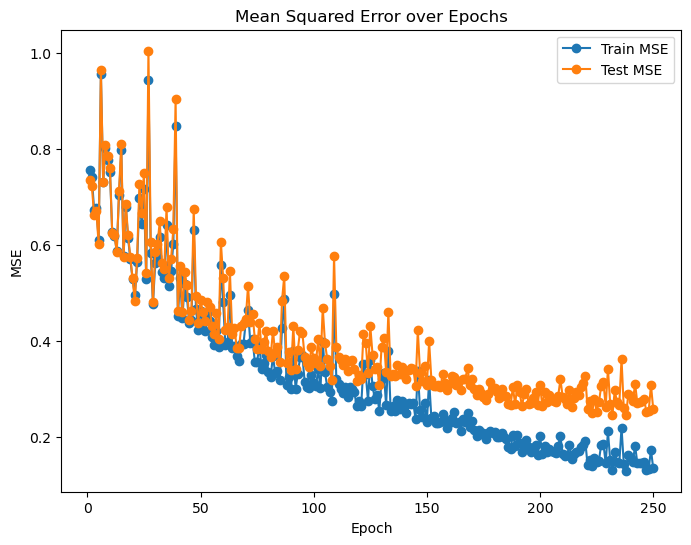

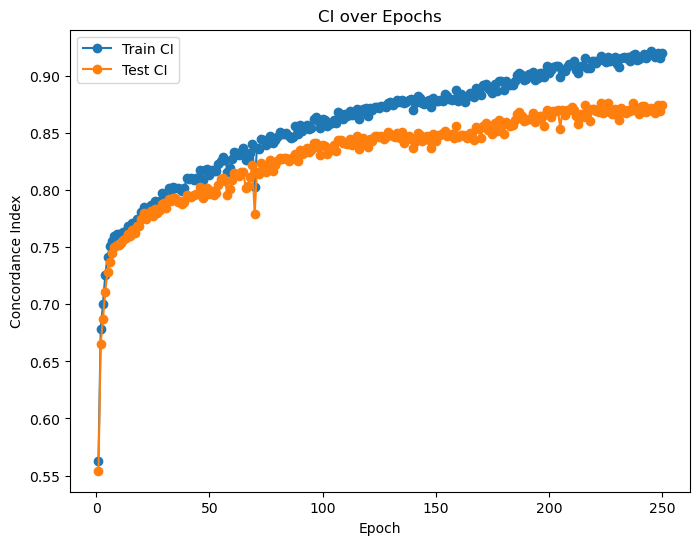

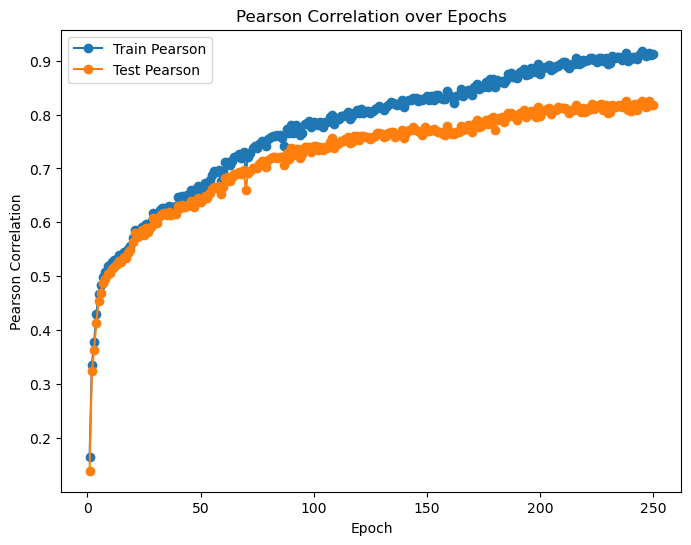

In [7]:
plot_metrics('')